# Google Earth Engine Panel Data Creation

## Initialize

In [18]:
!pip install geemap
#!pip install ee

In [19]:
!pip install uszipcode

In [104]:
#GEE specific
import ee
import geemap
import math

#plotting and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from time import time

# Postgres
import psycopg2

# Zip code info
from uszipcode import SearchEngine

In [91]:
#!earthengine authenticate

In [105]:
#Initialize Google Earth Engine
#ee.Authenticate() #just needed the 1st time
ee.Initialize()

In [106]:
# Check if geemap is working as intended - plot the leaflet map
Map = geemap.Map()

## Load Feature Collection - Shapefiles

In [107]:
#Data loads

#loads feature collection data from Google Earth Engine - We can also upload other feature collections
counties = ee.FeatureCollection("TIGER/2018/Counties")

#filter LA County
la_county = counties.filter(ee.Filter.eq('NAME', 'Los Angeles'))
sc_county = counties.filter(ee.Filter.eq('NAME', 'Santa Clara'))

In [108]:
la_county, sc_county

(<ee.featurecollection.FeatureCollection at 0x7f118d3cd370>,
 <ee.featurecollection.FeatureCollection at 0x7f118d3cd4f0>)

In [109]:
#Income Data
la_county_income = ee.FeatureCollection("projects/california-lawn-detection/assets/lacountyincome-final")

## Load NAIP Imagery

In [110]:
def apply_3bands(image, band):
    i_8_bit = image.select(band).toUint8()
    square = ee.Kernel.square(**{'radius': 4})
    entropy = i_8_bit.entropy(square)
    glcm = i_8_bit.glcmTexture(**{'size': 4})
    contrast = glcm.select(str(band)+'_contrast')
    
    # Create a list of weights for a 9x9 kernel.
    list = [1, 1, 1, 1, 1, 1, 1, 1, 1]
    # The center of the kernel is zero.
    centerList = [1, 1, 1, 1, 0, 1, 1, 1, 1]
    # Assemble a list of lists: the 9x9 kernel weights as a 2-D matrix.
    lists = [list, list, list, list, centerList, list, list, list, list]
    # Create the kernel from the weights.
    # Non-zero weights represent the spatial neighborhood.
    kernel = ee.Kernel.fixed(9, 9, lists, -4, -4, False)
    neighs = i_8_bit.neighborhoodToBands(kernel)
    gearys = i_8_bit.subtract(neighs).pow(2).reduce(ee.Reducer.sum()).divide(math.pow(9, 2))
    image = image.addBands(entropy.rename(str(band)+'_Entropy')).addBands(contrast.rename(str(band)+'_Contrast')).addBands(gearys.rename(str(band)+'_Gearys'))   
    return image

def add_neighborhood_bands(image):
    bands = ['R', 'G', 'B', 'N']
    for band in bands:
        image = apply_3bands(image, band)
    return image
    
def add_NDVI(image):
    image = image.addBands(image.normalizedDifference(['N','R']).rename('NDVI'))
    return image
     

In [111]:
def get_images(param_dict):
    source_image_collection = params['source_image_collection']
    years = param_dict['years']
    counties = param_dict['counties']

    image_names = []
    images = []

    combos = list(itertools.product(years, counties.keys()))
    for i in combos:
        year = str(i[0])
        county = i[1]

        image_name = str(i[0])+'_'+i[1]
        image_names.append(image_name)

        image = ee.ImageCollection(source_image_collection)\
                                .filterDate(f'{year}-01-01', f'{year}-12-31')\
                                .select(['R','G','B','N'])\
                                .median().clip(counties[county])
        images.append(image)
        images_with_3band = list(map(add_neighborhood_bands, images))
        images_with_NDVI = list(map(add_NDVI, images_with_3band))
    return dict(zip(image_names, images_with_NDVI))

    
    

In [112]:
params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2010,2012,2014,2016,2018,2020],
        'counties': {'la_county': la_county, 'sc_county': sc_county}
         }

images = get_images(params)
images

{'2010_la_county': <ee.image.Image at 0x7f118d2e3f40>,
 '2010_sc_county': <ee.image.Image at 0x7f118d2e8160>,
 '2012_la_county': <ee.image.Image at 0x7f118d2e8340>,
 '2012_sc_county': <ee.image.Image at 0x7f118d2e8520>,
 '2014_la_county': <ee.image.Image at 0x7f118d2e8700>,
 '2014_sc_county': <ee.image.Image at 0x7f118d2e88e0>,
 '2016_la_county': <ee.image.Image at 0x7f118d2e8ac0>,
 '2016_sc_county': <ee.image.Image at 0x7f118d2e8ca0>,
 '2018_la_county': <ee.image.Image at 0x7f118d2e8e80>,
 '2018_sc_county': <ee.image.Image at 0x7f118d2eb0a0>,
 '2020_la_county': <ee.image.Image at 0x7f118d2eb280>,
 '2020_sc_county': <ee.image.Image at 0x7f118d2eb460>}

In [113]:
#see what bands each image has:
images['2020_la_county'].bandNames().getInfo()

['R',
 'G',
 'B',
 'N',
 'R_Entropy',
 'R_Contrast',
 'R_Gearys',
 'G_Entropy',
 'G_Contrast',
 'G_Gearys',
 'B_Entropy',
 'B_Contrast',
 'B_Gearys',
 'N_Entropy',
 'N_Contrast',
 'N_Gearys',
 'NDVI']

In [114]:
#test to see if NAIP plot looks correct
Map.addLayer(images['2020_la_county'], {}, 'NAIP Test')

In [115]:
#test to see if NDVI plot looks correct (define a different location in santa clara county just for visibility)
source_image = images['2020_sc_county']

test_ndvi = source_image.normalizedDifference(['N', 'R']).rename('2020_NDVI')
test_ndvi

In [116]:
Map.addLayer(test_ndvi,{min : -1, max : 1, 'palette' : ['blue', 'white', 'green']}, 'NDVI Test')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Load Labeled Data

In [117]:
## Loading feature collections from Google Earth Engine

#water = ee.FeatureCollection("projects/california-lawn-detection/assets/water_torrance")
water_training = ee.FeatureCollection("projects/california-lawn-detection/assets/water_training")
trees_training = ee.FeatureCollection("projects/california-lawn-detection/assets/trees_training")
grass_training = ee.FeatureCollection("projects/california-lawn-detection/assets/grass_training")
turf_training = ee.FeatureCollection("projects/california-lawn-detection/assets/turf_training")
#pv_training = ee.FeatureCollection("projects/california-lawn-detection/assets/pv_training")
impervious_training = ee.FeatureCollection("projects/california-lawn-detection/assets/impervious_training").limit(50)
soil_training = ee.FeatureCollection("projects/california-lawn-detection/assets/soil_training").limit(50)

LABELED_SET = water_training.merge(trees_training).merge(grass_training).merge(turf_training).merge(impervious_training).merge(soil_training)

In [118]:
water_test = ee.FeatureCollection("projects/california-lawn-detection/assets/water_test")
vegetation_trees_test = ee.FeatureCollection("projects/california-lawn-detection/assets/trees_test")
vegetation_grass_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/grass_test")
turf_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/turf_test")
#pv_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/pv_test")
impervious_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/impervious_test")
soil_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/soil_test")

TEST_SET = water_test.merge(vegetation_trees_test).merge(vegetation_grass_test).merge(turf_test).merge(impervious_test).merge(soil_test)

## Build Training Set

In [119]:
training_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2020],
        'counties': {'lacounty': la_county}
         }

TRAINING_IMAGE = get_images(training_image_params)['2020_lacounty']

In [120]:
# Overlay the points on the imagery to get training.
LABEL = 'landcover'
BANDS = ['R', 'G', 'B', 'N', 'NDVI',
         'R_Entropy',
         'R_Contrast',
         'R_Gearys',
         'G_Entropy',
         'G_Contrast',
         'G_Gearys',
         'B_Entropy',
         'B_Contrast',
         'B_Gearys',
         'N_Entropy', 
         'N_Contrast', 
         'N_Gearys']

train_data = TRAINING_IMAGE.select(BANDS).sampleRegions(**{
  'collection': LABELED_SET,
  'properties': [LABEL],
  'scale': 1
})

test_data = TRAINING_IMAGE.select(BANDS).sampleRegions(**{
  'collection': TEST_SET,
  'properties': [LABEL],
  'scale': 1
})

In [121]:
set(BANDS)==set(TRAINING_IMAGE.bandNames().getInfo())

True

In [122]:
print("Training Set Size in Pixels", train_data.aggregate_count('R').getInfo())

Training Set Size in Pixels 169069


In [123]:
print("Test Set Size in Pixels", test_data.aggregate_count('R').getInfo())

Test Set Size in Pixels 97964


## Machine Learning Model

In [124]:
clf = ee.Classifier.smileRandomForest(numberOfTrees = 200, minLeafPopulation = 5, bagFraction= 0.7)\
                   .train(train_data, LABEL, BANDS)
clf

In [125]:
training_image_classified = TRAINING_IMAGE.select(BANDS)\
                                          .classify(clf)


In [126]:
legend_keys = ['water', 'vegetation_trees', 'vegetation_grass', 'turf','impervious','soil']
legend_colors = ['#0B6AEF', '#097407', '#0CE708', '#8C46D2' ,' #A1A8AF','#D47911']

Map.addLayer(training_image_classified, {'min': 1, 'max': 7, 'palette': legend_colors}, 'Classification')

In [127]:
training_image_classified.bandNames().getInfo()

['classification']

In [128]:
Map

Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

## Evaluation Metrics

### Train Accuracy

In [129]:
train_accuracy = train_data.classify(clf).errorMatrix('landcover', 'classification')
train_conf_matrix = train_accuracy.getInfo()

In [130]:
print(f'Spot check to confirm pixel numbers: {np.array(train_conf_matrix).sum()}')
train_conf_matrix

Spot check to confirm pixel numbers: 169069


[[1331, 1, 0, 1, 1, 0],
 [0, 9475, 40, 8, 12, 11],
 [0, 93, 6591, 2, 0, 38],
 [0, 15, 1, 2398, 5, 0],
 [0, 3, 0, 4, 21239, 60],
 [0, 12, 1, 2, 37, 127688]]

### Test Accuracy

In [131]:
test_accuracy = test_data.classify(clf).errorMatrix('landcover', 'classification')
test_conf_matrix = test_accuracy.getInfo()

In [132]:
print(f'Spot check to confirm pixel numbers: {np.array(test_conf_matrix).sum()}')
test_conf_matrix

Spot check to confirm pixel numbers: 97964


[[275, 0, 0, 0, 0, 0],
 [0, 2620, 141, 16, 12, 12],
 [0, 164, 1327, 3, 0, 38],
 [0, 29, 0, 602, 222, 7],
 [9, 3, 4, 847, 70443, 1647],
 [0, 36, 151, 23, 387, 18946]]

## Binary Classification and Area Calculation

In [134]:
def area_calculation(image, class_number, shape, pixel_scale = 20):

    if type(shape) == str:
        shape = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', shape))

    areaImage = image.eq(class_number).multiply(ee.Image.pixelArea())

    area = areaImage.reduceRegion(
        reducer = ee.Reducer.sum(),
        geometry = shape,
        scale = pixel_scale,
        maxPixels = 1e13)


    area_sq_m = area.getInfo().get('classification')

    #area_sq_km = area_sq_m / 1e6

    return area_sq_m

In [150]:
def ndvi_calculation(image, class_number, shape, ref_image, pixel_scale=1):
    
    if type(shape) == str:
        shape = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', shape))
        
    ndvi = ref_image.normalizedDifference(['N', 'R'])
    image_clipped = image.clip(shape)
    
    NDVI_for_class = ndvi.updateMask(image_clipped.select('classification').eq(class_number))
    
    reducer = ee.Reducer.mean()\
                        .combine(ee.Reducer.max(),sharedInputs=True)\
                        .combine(ee.Reducer.min(),sharedInputs=True)
    
    
    qty = NDVI_for_class.reduceRegion(
        reducer = reducer, 
        geometry = shape, 
        scale = pixel_scale, 
        maxPixels = 1e13)
    return qty



### Create Panel Data

In [136]:
la_county_income_zipcode2 = ee.FeatureCollection("projects/california-lawn-detection/assets/income_zipcode2019")
la_county_income_zipcode = la_county_income_zipcode2.select(ee.List(['zipcode', '2019zipcod','shape_area']), ee.List(['ZipCode', 'Median_Income','Area_sqft']))

In [144]:
year_list = [2010,2012, 2014, 2016, 2018,2020]
#zipcode_list = ['90802','90732','90744']
zipcode_list = ['90802','90732','90744', '90011', '91331', '90650', '90201', '90250', '90044', '90805', '90280', '91342', '91744', '91335', '91706', '90706', '90003']

In [138]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [ ]:
connection = psycopg2.connect(
    user = "postgres",
    password = "&j>n!_nL]k&wWdE>*TVds4P6",
    host = "3.239.228.42",
    port = "5432",
    database = "postgres"
)
cursor = connection.cursor()

In [146]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select zipcode 
from zipcode_detail
where county = 'Los Angeles County'
order by zipcode;

"""

zipcodes_df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

zipcode_list = zipcodes_df['zipcode'].values.tolist()

In [147]:
zipcode_list

['90001',
 '90002',
 '90003',
 '90004',
 '90005',
 '90006',
 '90007',
 '90008',
 '90009',
 '90010',
 '90011',
 '90012',
 '90013',
 '90014',
 '90015',
 '90016',
 '90017',
 '90018',
 '90019',
 '90020',
 '90021',
 '90022',
 '90023',
 '90024',
 '90025',
 '90026',
 '90027',
 '90028',
 '90029',
 '90030',
 '90031',
 '90032',
 '90033',
 '90034',
 '90035',
 '90036',
 '90037',
 '90038',
 '90039',
 '90040',
 '90041',
 '90042',
 '90043',
 '90044',
 '90045',
 '90046',
 '90047',
 '90048',
 '90049',
 '90050',
 '90051',
 '90052',
 '90053',
 '90054',
 '90055',
 '90056',
 '90057',
 '90058',
 '90059',
 '90060',
 '90061',
 '90062',
 '90063',
 '90064',
 '90065',
 '90066',
 '90067',
 '90068',
 '90069',
 '90070',
 '90071',
 '90072',
 '90073',
 '90074',
 '90075',
 '90076',
 '90077',
 '90078',
 '90079',
 '90080',
 '90081',
 '90082',
 '90083',
 '90084',
 '90086',
 '90087',
 '90088',
 '90089',
 '90090',
 '90091',
 '90093',
 '90094',
 '90095',
 '90096',
 '90099',
 '90101',
 '90102',
 '90103',
 '90189',
 '90201',


In [141]:
test_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : year_list,
        'counties': {'lacounty': la_county}
         }

inference_images = get_images(test_image_params)
inference_images

{'2010_lacounty': <ee.image.Image at 0x7f118d2a9a90>,
 '2012_lacounty': <ee.image.Image at 0x7f118d2a9c70>,
 '2014_lacounty': <ee.image.Image at 0x7f118d2a9e50>,
 '2016_lacounty': <ee.image.Image at 0x7f118d2ab070>,
 '2018_lacounty': <ee.image.Image at 0x7f118d2ab250>,
 '2020_lacounty': <ee.image.Image at 0x7f118d2ab430>}

In [151]:

sr = SearchEngine()

def insert_panel_zipcode(year, zipcode, water_area, tree_area, grass_area, turf_area, 
                        impervious_area, soil_area, total_area,
                        tree_ndvi_mean, tree_ndvi_max, tree_ndvi_min,
                        grass_ndvi_mean, grass_ndvi_max, grass_ndvi_min):

    connection.rollback()
    
    z = sr.by_zipcode(zipcode)
    city = z.major_city
    state = z.state_abbr
    print("state", state)
    county = z.county
    median_income = z.median_household_income
    
    panel_zipcode_dict ={ 'item' : (state, 
                                    county, 
                                    zipcode, 
                                    city, 
                                    year, 
                                    round(total_area, 8),
                                    round(water_area, 8),
                                    round(grass_area, 8), 
                                    round(tree_area, 8),
                                    0.0, 
                                    round(impervious_area, 8), 
                                    round(soil_area, 8), 
                                    round(turf_area,  8),
                                    median_income, 
                                    0.0,
                                    tree_ndvi_mean, 
                                    tree_ndvi_max, 
                                    tree_ndvi_min,
                                    grass_ndvi_mean, 
                                    grass_ndvi_max, 
                                    grass_ndvi_min)
    }

    
    print(panel_zipcode_dict)
    
    columns= panel_zipcode_dict.keys()
    
    for i in panel_zipcode_dict.values():
        
        query = '''

        INSERT INTO panel_zipcode (state, 
                                    county, 
                                    zipcode, 
                                    city_neighborhood, 
                                    year, 
                                    polygon_area, 
                                    water_area, 
                                    lawn_area, 
                                    tree_area, 
                                    pv_area, 
                                    impervious_area, 
                                    soil_area, 
                                    turf_area, 
                                    median_income, 
                                    water_usage,
                                    tree_ndvi_mean, 
                                    tree_ndvi_max, 
                                    tree_ndvi_min,
                                    grass_ndvi_mean, 
                                    grass_ndvi_max, 
                                    grass_ndvi_min)
            VALUES {}; '''.format(i)

        try:
            cursor.execute(query)
        
        except (Exception, psycopg2.DatabaseError) as error:
            print(error)
    
        finally:
        
            if connection is not None:
                connection.commit()


In [152]:
keys = {'year','polygon','water_area','vegetation_trees_area', 
        'vegetation_grass_area', 'turf_area', 'impervious_area',
        'soil_area', 'total_area','tree_ndvi_mean', 'tree_ndvi_max','tree_ndvi_min',
       'grass_ndvi_mean', 'grass_ndvi_max','grass_ndvi_min'}


dictionary = {}
for i in keys:
    dictionary[i] = []

for i in zipcode_list:
    for j in list(inference_images.items()):
        im = j[1]
        imagery = im.select(BANDS).classify(clf)
        name = j[0]
        
        zipcode = i
        
        start = time()
        polygon = la_county_income_zipcode.filter(ee.Filter.eq('ZipCode', i))

        dictionary['year'].append(j[0][:4]) 
        dictionary['polygon'].append(i)
        year = j[0][:4]
        
        water_area = area_calculation(imagery, 0, polygon, 20)
        dictionary['water_area'].append(water_area)

        vegetation_trees_area = area_calculation(imagery, 1, polygon, 20)
        dictionary['vegetation_trees_area'].append(vegetation_trees_area)

        vegetation_grass_area = area_calculation(imagery, 2, polygon, 20)
        dictionary['vegetation_grass_area'].append(vegetation_grass_area)

        turf_area = area_calculation(imagery, 3, polygon, 20)
        dictionary['turf_area'].append(turf_area)

        impervious_area = area_calculation(imagery, 4, polygon, 20)
        dictionary['impervious_area'].append(impervious_area)

        soil_area = area_calculation(imagery, 5, polygon, 20)
        dictionary['soil_area'].append(soil_area)

        total_area = water_area + vegetation_trees_area + vegetation_grass_area + turf_area + impervious_area + soil_area
        dictionary['total_area'].append(total_area)
        
        tree_ndvi_mean, tree_ndvi_max, tree_ndvi_min = ndvi_calculation(imagery, 1, polygon, ref_image = im, pixel_scale=5).getInfo().values()
        dictionary['tree_ndvi_mean'].append(tree_ndvi_mean)
        dictionary['tree_ndvi_max'].append(tree_ndvi_max)
        dictionary['tree_ndvi_min'].append(tree_ndvi_min)
        
        grass_ndvi_mean, grass_ndvi_max, grass_ndvi_min = ndvi_calculation(imagery, 2, polygon, ref_image = im, pixel_scale=5).getInfo().values()
        dictionary['grass_ndvi_mean'].append(grass_ndvi_mean)
        dictionary['grass_ndvi_max'].append(grass_ndvi_max)
        dictionary['grass_ndvi_min'].append(grass_ndvi_min)
        
        
        
        end = time()
        print(f'Zip Code: {i}, Year: {j[0][:4]} ::: completed in {end-start} seconds.')
              
        insert_panel_zipcode(year, zipcode, water_area, vegetation_trees_area, vegetation_grass_area, 
                             turf_area, impervious_area, soil_area, total_area,
                            tree_ndvi_mean, tree_ndvi_max, tree_ndvi_min,
                            grass_ndvi_mean, grass_ndvi_max, grass_ndvi_min)
              
              

Zip Code: 90001, Year: 2010 ::: completed in 45.36080503463745 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90001', 'Los Angeles', '2010', 8878203.51609161, 22282.22737522, 274714.07934187, 1147390.15421873, 0.0, 1163002.3392529, 6256917.38240679, 13897.33349609, 35097, 0.0, 0.6666666666666666, 0.22998719632171916, -1, 0.673469387755102, 0.17699147746948193, 0.07155322862129145)}
Zip Code: 90001, Year: 2012 ::: completed in 96.90854167938232 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90001', 'Los Angeles', '2012', 8878203.51609161, 1282038.56532509, 108285.26308055, 74780.17630005, 0.0, 7348245.33917523, 9926.70800781, 54927.46420288, 35097, 0.0, 0.7142857142857143, 0.29105059373952635, 0.1079646017699115, 0.7444444444444445, 0.38344264305609155, 0.06840390879478828)}
Zip Code: 90001, Year: 2014 ::: completed in 105.4730224609375 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90001', 'Los Angeles', '2014', 8878203.51609161, 143613.27872685, 305168.55

Zip Code: 90004, Year: 2016 ::: completed in 97.1126561164856 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90004', 'Los Angeles', '2016', 7798829.96433177, 0, 568861.61481347, 435820.77200796, 0.0, 4056694.0527169, 2228194.98922179, 509258.53557165, 37976, 0.0, 0.5855855855855856, 0.2901218130542927, -0.02912621359223301, 0.5862068965517241, 0.25186365892634527, 0.06109324758842444)}
Zip Code: 90004, Year: 2018 ::: completed in 314.84832215309143 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90004', 'Los Angeles', '2018', 7798829.96433179, 11290.97766604, 1010337.7448399, 607013.54793258, 0.0, 5331765.64371232, 333499.77983315, 504922.2703478, 37976, 0.0, 0.635593220338983, 0.3299781510935064, -0.14754098360655737, 0.6244897959183674, 0.3360607964398713, 0.07692307692307693)}
Zip Code: 90004, Year: 2020 ::: completed in 110.95985174179077 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90004', 'Los Angeles', '2020', 7798829.96433177, 330.50738525, 826196

Zip Code: 90008, Year: 2010 ::: completed in 117.38099551200867 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90008', 'Los Angeles', '2010', 9906910.27365783, 18851.57327271, 1622145.36932014, 1362084.91183855, 0.0, 3562179.66082417, 3171078.87300822, 170569.88539405, 38210, 0.0, 0.9508196721311475, 0.3406700907315986, -0.46808510638297873, 1, 0.259763707095443, 0.0542907180385289)}
Zip Code: 90008, Year: 2012 ::: completed in 100.39195370674133 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90008', 'Los Angeles', '2012', 9906910.27365783, 1449474.42830415, 803163.39572503, 787049.24179568, 0.0, 6357808.38179573, 29436.89852905, 479977.92750819, 38210, 0.0, 0.7256637168141593, 0.276746755402304, -0.47126436781609193, 0.7309417040358744, 0.40010464889646596, 0.06666666666666667)}
Zip Code: 90008, Year: 2014 ::: completed in 122.79360699653625 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90008', 'Los Angeles', '2014', 9906910.27365783, 28182.12765682, 119

Zip Code: 90011, Year: 2016 ::: completed in 130.93027234077454 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90011', 'Los Angeles', '2016', 11109429.16197341, 330.78851318, 155587.95835081, 163322.64805908, 0.0, 5463049.95881238, 4871802.05043323, 455335.75780472, 30171, 0.0, 0.5081967213114754, 0.2615443462861401, 0.0364963503649635, 0.5161290322580645, 0.2183264736038045, 0.06993006993006994)}
Zip Code: 90011, Year: 2018 ::: completed in 112.18941569328308 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90011', 'Los Angeles', '2018', 11109429.16197343, 49376.06197929, 180194.16589499, 152318.10487767, 0.0, 9585206.44299341, 711883.73617865, 430450.65004943, 30171, 0.0, 0.6143497757847534, 0.3234382122705465, -0.45454545454545453, 0.6569037656903766, 0.33135809159660407, 0.0711864406779661)}
Zip Code: 90011, Year: 2020 ::: completed in 146.63967871665955 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90011', 'Los Angeles', '2020', 11109429.16197341, 330.

Zip Code: 90015, Year: 2010 ::: completed in 80.20939040184021 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90015', 'Los Angeles', '2010', 4329235.72938771, 45.37924015, 93161.76466687, 160704.30127839, 0.0, 1015417.56067984, 3043005.06368923, 16901.65983324, 27393, 0.0, 0.4980392156862745, 0.23595163073070277, -1, 0.4793388429752066, 0.17615973036673477, 0.07142857142857142)}
Zip Code: 90015, Year: 2012 ::: completed in 60.60638236999512 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90015', 'Los Angeles', '2012', 4329235.72938771, 1068792.87038335, 21841.37498301, 9961.3740737, 0.0, 3214629.67290721, 0, 14010.43704044, 27393, 0.0, 0.6502732240437158, 0.2866945955932253, 0.14545454545454545, 0.766497461928934, 0.4451939737044843, 0.11594202898550725)}
Zip Code: 90015, Year: 2014 ::: completed in 64.0831208229065 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90015', 'Los Angeles', '2014', 4329235.72938771, 128040.33394428, 49859.19930193, 39192.10881731

Zip Code: 90018, Year: 2016 ::: completed in 103.06409239768982 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90018', 'Los Angeles', '2016', 7713708.26390368, 0, 124988.89980696, 67733.84691629, 0.0, 4398307.03508252, 2871003.53625692, 251674.94584099, 32447, 0.0, 0.5137614678899083, 0.2634415986663039, -0.025477707006369428, 0.5695067264573991, 0.20529279669318204, 0.06713780918727916)}
Zip Code: 90018, Year: 2018 ::: completed in 83.1229019165039 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90018', 'Los Angeles', '2018', 7713708.26390368, 15670.42776549, 336023.23195442, 152954.95967132, 0.0, 6067225.0914455, 752088.85948223, 389745.69358473, 32447, 0.0, 0.6016949152542372, 0.306630467651977, -0.10407239819004525, 0.611336032388664, 0.2995789703165981, 0.0711864406779661)}
Zip Code: 90018, Year: 2020 ::: completed in 110.71185040473938 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90018', 'Los Angeles', '2020', 7713708.26390368, 0, 304983.91811452, 5

Zip Code: 90022, Year: 2010 ::: completed in 172.3581473827362 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90022', 'Los Angeles', '2010', 11039800.06231918, 8266.01397705, 153881.83236132, 268643.24374773, 0.0, 1759725.07229519, 8843993.00381973, 5290.89611816, 38925, 0.0, 0.5542168674698795, 0.22678425312829217, -1, 0.49783549783549785, 0.1836321275911692, 0.06796116504854369)}
Zip Code: 90022, Year: 2012 ::: completed in 137.74233412742615 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90022', 'Los Angeles', '2012', 11039800.06231919, 1111952.23725035, 188435.52387959, 121623.92059721, 0.0, 9562909.43973571, 26470.90296188, 28408.03789445, 38925, 0.0, 0.7012448132780082, 0.292110635591914, 0.05555555555555555, 0.7313432835820896, 0.3454794704857678, 0.06666666666666667)}
Zip Code: 90022, Year: 2014 ::: completed in 161.13340497016907 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90022', 'Los Angeles', '2014', 11039800.0623192, 102804.04294218, 414573

Zip Code: 90025, Year: 2016 ::: completed in 106.76597499847412 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90025', 'Los Angeles', '2016', 6456532.41323182, 1983.6784668, 338688.5426388, 148396.08951811, 0.0, 4627845.14632029, 857276.07887418, 482342.87741364, 73478, 0.0, 0.5911111111111111, 0.308841483464599, -0.07317073170731707, 0.5757575757575758, 0.25321086819521416, 0.06319702602230483)}
Zip Code: 90025, Year: 2018 ::: completed in 98.96317982673645 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90025', 'Los Angeles', '2018', 6456532.41323182, 92473.73279323, 388664.31499287, 306686.6306868, 0.0, 5018581.83410214, 106373.7819233, 543752.11873348, 73478, 0.0, 0.6277056277056277, 0.32841746143230977, -0.26666666666666666, 0.6305220883534136, 0.34740997720507394, 0.08823529411764706)}
Zip Code: 90025, Year: 2020 ::: completed in 103.94878911972046 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90025', 'Los Angeles', '2020', 6456532.41323182, 22678.35

Zip Code: 90029, Year: 2010 ::: completed in 57.95323395729065 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90029', 'Los Angeles', '2010', 3699879.54503676, 0, 293577.74908842, 59349.39307502, 0.0, 1135827.56769481, 2190509.08218671, 20615.7529918, 36979, 0.0, 0.7484662576687117, 0.25109044163601524, 0.06532663316582915, 0.9225806451612903, 0.20600788494116276, 0.06885245901639345)}
Zip Code: 90029, Year: 2012 ::: completed in 41.393210887908936 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90029', 'Los Angeles', '2012', 3699879.54503676, 593091.03797739, 46862.39421614, 22963.34967388, 0.0, 3006029.89665288, 0, 30932.86651647, 36979, 0.0, 0.6651162790697674, 0.2724543966803127, 0.11504424778761062, 0.7395833333333334, 0.39417727627520893, 0.08666666666666667)}
Zip Code: 90029, Year: 2014 ::: completed in 50.098201751708984 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90029', 'Los Angeles', '2014', 3699879.54503676, 58016.33152705, 167565.02933278, 74

Zip Code: 90032, Year: 2016 ::: completed in 193.68658638000488 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90032', 'Los Angeles', '2016', 13027648.09205416, 0, 284942.69314312, 402934.61791777, 0.0, 1652946.21379251, 10601994.61560236, 84829.9515984, 46508, 0.0, 0.512, 0.2479067770155339, 0.028037383177570093, 0.46956521739130436, 0.19252767703075432, 0.05802047781569966)}
Zip Code: 90032, Year: 2018 ::: completed in 224.25116610527039 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90032', 'Los Angeles', '2018', 13027648.09205419, 14872.79748535, 919040.18460861, 584390.14367664, 0.0, 7525153.17045911, 3176077.70842608, 808114.08739839, 46508, 0.0, 0.6888888888888889, 0.31813026258893584, -0.42857142857142855, 0.6888888888888889, 0.28656326597731413, 0.05647840531561462)}
Zip Code: 90032, Year: 2020 ::: completed in 235.41990399360657 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90032', 'Los Angeles', '2020', 13027648.09205418, 0, 1372713.80163359, 1

Zip Code: 90036, Year: 2010 ::: completed in 91.67275905609131 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90036', 'Los Angeles', '2010', 6464937.5861431, 0, 1436179.25659, 256063.92372724, 0.0, 2305800.71030848, 2367138.24579372, 99755.44972367, 71589, 0.0, 1, 0.2991058081489391, -0.4523809523809524, 0.8095238095238095, 0.22747209504993618, 0.06761565836298933)}
Zip Code: 90036, Year: 2012 ::: completed in 71.93790030479431 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90036', 'Los Angeles', '2012', 6464937.5861431, 1174741.36454791, 234064.72032207, 40273.79293763, 0.0, 4779228.52252113, 0, 236629.18581435, 71589, 0.0, 0.6910569105691057, 0.3055710149262114, -0.3968253968253968, 0.7154811715481172, 0.3964881102599811, 0.09454545454545454)}
Zip Code: 90036, Year: 2014 ::: completed in 73.6528069972992 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90036', 'Los Angeles', '2014', 6464937.5861431, 30624.24756183, 1145211.03713929, 358282.7791383, 0.0, 46

Zip Code: 90039, Year: 2016 ::: completed in 192.42558097839355 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90039', 'Los Angeles', '2016', 10499193.52285024, 0, 599472.43510982, 924654.05853415, 0.0, 3999289.78510156, 3963032.01557162, 1012745.2285331, 64080, 0.0, 0.5, 0.26108680935729717, 0.0136986301369863, 0.5141700404858299, 0.22668580109267977, 0.07011070110701106)}
Zip Code: 90039, Year: 2018 ::: completed in 144.73739361763 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90039', 'Los Angeles', '2018', 10499193.52285025, 25721.64339827, 1363166.2982587, 554039.66652629, 0.0, 7123994.39917495, 394630.425, 1037641.09049204, 64080, 0.0, 0.6818181818181818, 0.3345654073545109, -0.3469387755102041, 0.6713615023474179, 0.34654131358424733, 0.06756756756756757)}
Zip Code: 90039, Year: 2020 ::: completed in 192.44140887260437 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90039', 'Los Angeles', '2020', 10499193.52285025, 0, 1870822.48889388, 938816.2730012

Zip Code: 90043, Year: 2010 ::: completed in 151.82458877563477 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90043', 'Los Angeles', '2010', 10523612.36981859, 9924.19586182, 1742138.72738324, 1368795.60229049, 0.0, 2603819.10990505, 4641714.53485657, 157220.19952141, 40658, 0.0, 0.9590163934426229, 0.2910142965212451, -0.7407407407407407, 0.9615384615384616, 0.23319677953915013, 0.06993006993006994)}
Zip Code: 90043, Year: 2012 ::: completed in 125.57753133773804 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90043', 'Los Angeles', '2012', 10523612.3698186, 1281105.64696524, 246524.60259723, 87050.01836548, 0.0, 8670453.83069147, 429.35673708, 238048.9144621, 40658, 0.0, 0.6836158192090396, 0.2760861325257852, -0.2777777777777778, 0.7081081081081081, 0.3714875710657788, 0.09818181818181818)}
Zip Code: 90043, Year: 2014 ::: completed in 119.64021062850952 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90043', 'Los Angeles', '2014', 10523612.36981858, 4701

Zip Code: 90046, Year: 2016 ::: completed in 243.3212330341339 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90046', 'Los Angeles', '2016', 14655035.33452628, 0, 1069650.88680145, 3466467.35936411, 0.0, 5315640.45623839, 2166675.39046775, 2636601.24165458, 52641, 0.0, 0.6116504854368932, 0.2668110381177562, -0.05511811023622047, 0.5943396226415094, 0.2865456678668022, 0.011583011583011582)}
Zip Code: 90046, Year: 2018 ::: completed in 208.3203408718109 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90046', 'Los Angeles', '2018', 14655035.33452627, 12907.5260376, 2037320.35103353, 4263031.38303223, 0.0, 5638653.06518639, 873401.50877398, 1829721.50046255, 52641, 0.0, 0.6944444444444444, 0.3065632497260246, -0.3090909090909091, 0.6857142857142857, 0.3545841241275944, 0.056105610561056105)}
Zip Code: 90046, Year: 2020 ::: completed in 223.53833389282227 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90046', 'Los Angeles', '2020', 14655035.33452628, 660.63406

Zip Code: 90050, Year: 2010 ::: completed in 6.2756593227386475 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90050', 'Los Angeles', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90050, Year: 2012 ::: completed in 6.223706245422363 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90050', 'Los Angeles', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90050, Year: 2014 ::: completed in 5.929630756378174 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90050', 'Los Angeles', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, Non

Zip Code: 90053, Year: 2016 ::: completed in 5.6981213092803955 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90053', 'Los Angeles', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90053, Year: 2018 ::: completed in 6.009191513061523 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90053', 'Los Angeles', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90053, Year: 2020 ::: completed in 5.2511818408966064 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90053', 'Los Angeles', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, No

Zip Code: 90057, Year: 2010 ::: completed in 41.58524179458618 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90057', 'Los Angeles', '2010', 2406922.86112539, 4627.79275513, 56776.56862961, 116040.83173337, 0.0, 352030.76279728, 1874802.53997563, 2644.36523438, 28035, 0.0, 0.49767441860465117, 0.23149877734417496, -0.5061728395061729, 0.4166666666666667, 0.1710470828056893, 0.06976744186046512)}
Zip Code: 90057, Year: 2012 ::: completed in 35.26843500137329 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90057', 'Los Angeles', '2012', 2406922.86112539, 490419.17234677, 42342.53481457, 22204.75016348, 0.0, 1840645.51094241, 0, 11310.89285817, 28035, 0.0, 0.7261904761904762, 0.3068676025470634, 0.11538461538461539, 0.7393617021276596, 0.3912752282286457, 0.10367892976588629)}
Zip Code: 90057, Year: 2014 ::: completed in 39.395838499069214 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90057', 'Los Angeles', '2014', 2406922.86112539, 40669.05419814, 69566.6178

Zip Code: 90060, Year: 2016 ::: completed in 6.332840919494629 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90060', 'Los Angeles', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90060, Year: 2018 ::: completed in 6.184550762176514 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90060', 'Los Angeles', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90060, Year: 2020 ::: completed in 5.7169928550720215 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90060', 'Los Angeles', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, Non

Zip Code: 90064, Year: 2010 ::: completed in 149.72988510131836 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90064', 'Los Angeles', '2010', 10257499.87550348, 991.93756104, 2345747.43694243, 1466669.22446134, 0.0, 3987383.943427, 2284602.04735143, 172105.28576026, 84579, 0.0, 0.9279279279279279, 0.3274060590048079, -0.1509433962264151, 1, 0.26788968395365187, 0.056105610561056105)}
Zip Code: 90064, Year: 2012 ::: completed in 115.12746119499207 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90064', 'Los Angeles', '2012', 10257499.87550348, 1720361.34337266, 835189.44067694, 914932.97159855, 0.0, 6044439.45202732, 661.23623657, 741915.43159144, 84579, 0.0, 0.7454545454545455, 0.41602570064533556, -1, 0.7743589743589744, 0.43495870048390095, 0.10191082802547771)}
Zip Code: 90064, Year: 2014 ::: completed in 131.25955533981323 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90064', 'Los Angeles', '2014', 10257499.87550348, 38445.36742506, 1729461.11244519, 1

Zip Code: 90067, Year: 2016 ::: completed in 26.49949812889099 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90067', 'Los Angeles', '2016', 961811.66776566, 0, 53246.6199859, 14526.56967773, 0.0, 760369.75763215, 11887.25843721, 121781.46203266, 90972, 0.0, 0.5634517766497462, 0.3219579316356571, -0.07317073170731707, 0.5677966101694916, 0.29768253841657333, 0.07114624505928854)}
Zip Code: 90067, Year: 2018 ::: completed in 25.149576425552368 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90067', 'Los Angeles', '2018', 961811.66776566, 56868.45194942, 80713.33762171, 14741.77541636, 0.0, 727194.03408263, 3983.63379612, 78310.43489942, 90972, 0.0, 0.6440677966101694, 0.33134893447401886, -0.15254237288135594, 0.6451612903225806, 0.3616179938356649, 0.09558823529411764)}
Zip Code: 90067, Year: 2020 ::: completed in 26.99218773841858 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90067', 'Los Angeles', '2020', 961811.66776566, 16123.34971912, 57131.74133408,

Zip Code: 90071, Year: 2010 ::: completed in 16.69628143310547 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90071', 'Los Angeles', '2010', 375321.0595739, 1322.31848145, 52932.19406319, 40336.82553005, 0.0, 209158.68553072, 48930.93573046, 22640.10023804, None, 0.0, 0.7545454545454545, 0.18428000218194676, -0.9047619047619048, 0.44554455445544555, 0.16690166466035505, 0.0718954248366013)}
column "none" does not exist
LINE 24: ... 209158.68553072, 48930.93573046, 22640.10023804, None, 0.0,...
                                                              ^

Zip Code: 90071, Year: 2012 ::: completed in 14.295549869537354 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90071', 'Los Angeles', '2012', 375321.0595739, 64203.62434609, 12898.94917662, 1982.15517339, 0.0, 291262.1347618, 0, 4974.19611601, None, 0.0, 0.6842105263157895, 0.28612584930001145, 0.19069767441860466, 0.7723214285714286, 0.46044456610949935, 0.16331096196868009)}
column "none" does not exist
LINE 24

Zip Code: 90073, Year: 2020 ::: completed in 48.37223243713379 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90073', 'Los Angeles', '2020', 1647771.97531475, 14103.05617736, 117317.57863841, 281002.72233576, 0.0, 965976.86544656, 196551.47099526, 72820.28172141, None, 0.0, 0.5909090909090909, 0.307733957796517, -0.2972972972972973, 0.5327102803738317, 0.27182958369976756, 0.0627062706270627)}
column "none" does not exist
LINE 24: ...965976.86544656, 196551.47099526, 72820.28172141, None, 0.0,...
                                                              ^

Zip Code: 90074, Year: 2010 ::: completed in 6.247112512588501 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90074', 'Los Angeles', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90074, Year: 2012 

Zip Code: 90077, Year: 2014 ::: completed in 222.29786229133606 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90077', 'Los Angeles', '2014', 18741719.23827347, 60819.63216218, 2411611.7607313, 9568367.66508944, 0.0, 3944705.0317311, 389440.52814606, 2366774.62041339, 168036, 0.0, 0.7522935779816514, 0.27573111958661256, -0.5151515151515151, 0.7662337662337663, 0.407936672386614, 0.06796116504854369)}
Zip Code: 90077, Year: 2016 ::: completed in 237.60406589508057 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90077', 'Los Angeles', '2016', 18741719.23827348, 330.48812866, 1226694.43806009, 9392640.92992674, 0.0, 3226109.57244227, 1953450.03718752, 2942493.7725282, 168036, 0.0, 0.6632653061224489, 0.28193879795982996, -0.24074074074074073, 0.6561085972850679, 0.30829983168098724, 0.06474820143884892)}
Zip Code: 90077, Year: 2018 ::: completed in 226.9857280254364 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90077', 'Los Angeles', '2018', 18741719.2382734

Zip Code: 90080, Year: 2020 ::: completed in 6.358670234680176 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90080', 'Los Angeles', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90081, Year: 2010 ::: completed in 6.010778188705444 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90081', 'Los Angeles', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90081, Year: 2012 ::: completed in 6.472529888153076 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90081', 'Los Angeles', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None

Zip Code: 90084, Year: 2014 ::: completed in 6.191325902938843 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90084', 'Los Angeles', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90084, Year: 2016 ::: completed in 6.188692331314087 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90084', 'Los Angeles', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90084, Year: 2018 ::: completed in 6.308598279953003 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90084', 'Los Angeles', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None

Zip Code: 90088, Year: 2020 ::: completed in 6.224851369857788 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90088', 'Los Angeles', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90089, Year: 2010 ::: completed in 19.73411273956299 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90089', 'Los Angeles', '2010', 667870.60421897, 1653.44113159, 156051.04085298, 148081.20035149, 0.0, 271323.95127264, 83077.17081813, 7683.79979212, None, 0.0, 0.6040609137055838, 0.28366884616871335, -0.4939759036144578, 0.5573770491803278, 0.23396051479919153, 0.07092198581560284)}
column "none" does not exist
LINE 24: ..., 271323.95127264, 83077.17081813, 7683.79979212, None, 0.0,...
                                                              ^

Zip Code: 90089, Year: 2012 :

Zip Code: 90093, Year: 2010 ::: completed in 5.867480754852295 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90093', 'Los Angeles', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90093, Year: 2012 ::: completed in 6.043506383895874 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90093', 'Los Angeles', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90093, Year: 2014 ::: completed in 5.918064117431641 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90093', 'Los Angeles', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None

Zip Code: 90096, Year: 2012 ::: completed in 6.247804164886475 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90096', 'Los Angeles', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90096, Year: 2014 ::: completed in 6.209903717041016 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90096', 'Los Angeles', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90096, Year: 2016 ::: completed in 6.552885055541992 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90096', 'Los Angeles', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None

Zip Code: 90102, Year: 2018 ::: completed in 6.393857955932617 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90102', 'Los Angeles', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90102, Year: 2020 ::: completed in 5.709923267364502 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90102', 'Los Angeles', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Los Angeles', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90103, Year: 2010 ::: completed in 6.1703033447265625 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90103', 'Los Angeles', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, Non

Zip Code: 90202, Year: 2012 ::: completed in 6.2253546714782715 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90202', 'Bell', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...90202', 'Bell', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90202, Year: 2014 ::: completed in 6.806410312652588 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90202', 'Bell', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...90202', 'Bell', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90202, Year: 2016 ::: completed in 6.378117322921753 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90202', 'Bell', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
colum

Zip Code: 90211, Year: 2018 ::: completed in 39.05376124382019 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90211', 'Beverly Hills', '2018', 1819328.64605318, 9712.30174764, 203835.43192318, 42834.03110866, 0.0, 1331355.94921971, 90299.98876594, 141290.94328805, 68589, 0.0, 0.5745526838966203, 0.310914709961321, -0.19083969465648856, 0.5893536121673004, 0.3311523792368001, 0.09608540925266904)}
Zip Code: 90211, Year: 2020 ::: completed in 38.32207727432251 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90211', 'Beverly Hills', '2020', 1819328.64605318, 330.55142212, 89575.07240433, 59742.29502121, 0.0, 1133097.94395034, 456228.71658134, 80354.06667385, 68589, 0.0, 0.6047058823529412, 0.3045448817165292, -0.11553784860557768, 0.559748427672956, 0.23511886414695746, 0.0695970695970696)}
Zip Code: 90212, Year: 2010 ::: completed in 43.826844453811646 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90212', 'Beverly Hills', '2010', 2337850.74080524, 0, 270490.

Zip Code: 90221, Year: 2012 ::: completed in 130.70274925231934 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90221', 'Compton', '2012', 13874189.91577878, 2054481.70191627, 356873.05653363, 189202.83830866, 0.0, 11116382.56147927, 20201.61346436, 137048.1440766, 42853, 0.0, 0.7395833333333334, 0.2949268353955732, -0.0847457627118644, 0.7397260273972602, 0.38541606771771364, 0.07224334600760456)}
Zip Code: 90221, Year: 2014 ::: completed in 142.2675907611847 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90221', 'Compton', '2014', 13874189.91577877, 229727.28498882, 976580.99823166, 545528.74002757, 0.0, 11315969.51357397, 601558.82145697, 204824.55749978, 42853, 0.0, 0.5983935742971888, 0.29544999088865875, -0.34673366834170855, 0.6812749003984063, 0.3107939187863832, 0.07011070110701106)}
Zip Code: 90221, Year: 2016 ::: completed in 156.2541799545288 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90221', 'Compton', '2016', 13874189.91577879, 0, 389552.9

Zip Code: 90224, Year: 2018 ::: completed in 5.991151571273804 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90224', 'Compton', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...24', 'Compton', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90224, Year: 2020 ::: completed in 8.636142492294312 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90224', 'Compton', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...24', 'Compton', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90230, Year: 2010 ::: completed in 172.32449555397034 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90230', 'Culver City', '2010', 11200958.49948372, 330.73220825, 2099748.3561156, 790909.56959085,

Zip Code: 90233, Year: 2012 ::: completed in 6.222806930541992 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90233', 'Culver City', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Culver City', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90233, Year: 2014 ::: completed in 6.281538724899292 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90233', 'Culver City', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Culver City', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90233, Year: 2016 ::: completed in 6.1455230712890625 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90233', 'Culver City', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, Non

Zip Code: 90241, Year: 2018 ::: completed in 174.10431337356567 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90241', 'Downey', '2018', 12956707.20218482, 48615.64854162, 691895.28609116, 695414.6312883, 0.0, 8282732.73584954, 2942768.98164565, 295279.91876855, 56479, 0.0, 0.6483516483516484, 0.3290986579422711, -0.21739130434782608, 0.6475409836065574, 0.2845148280612125, 0.06040268456375839)}
Zip Code: 90241, Year: 2020 ::: completed in 190.25417637825012 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90241', 'Downey', '2020', 12956707.20218481, 0, 538320.97849564, 1382526.73360261, 0.0, 3545521.84728944, 7071989.71453594, 418347.92826119, 56479, 0.0, 0.6650717703349283, 0.3295288472550938, 0.03044496487119438, 0.6636363636363637, 0.28334924106967285, 0.016100178890876567)}
Zip Code: 90242, Year: 2010 ::: completed in 172.32508301734924 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90242', 'Downey', '2010', 11517221.08880999, 14113.89581538, 407514.198

Zip Code: 90248, Year: 2012 ::: completed in 138.11281538009644 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90248', 'Gardena', '2012', 12165759.3147779, 2682926.50710677, 242149.75481508, 160546.32688299, 0.0, 9025694.40573655, 7092.81714968, 47349.50308682, 52013, 0.0, 0.7227722772277227, 0.3284777127766566, -0.7192982456140351, 0.7116279069767442, 0.3498984914276736, 0.06484641638225255)}
Zip Code: 90248, Year: 2014 ::: completed in 260.28816986083984 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90248', 'Gardena', '2014', 12165759.31477789, 148439.32909462, 378873.0266525, 293878.12389826, 0.0, 10891450.68768415, 298655.68559881, 154462.46184956, 52013, 0.0, 0.6085106382978723, 0.28244781867182644, -0.475, 0.6349206349206349, 0.28712543925768197, 0.06840390879478828)}
Zip Code: 90248, Year: 2016 ::: completed in 171.51460933685303 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90248', 'Gardena', '2016', 12165759.31477791, 0, 209945.26780252, 147486.

Zip Code: 90251, Year: 2018 ::: completed in 6.1464316844940186 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90251', 'Hawthorne', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'Hawthorne', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90251, Year: 2020 ::: completed in 6.514411449432373 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90251', 'Hawthorne', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'Hawthorne', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90254, Year: 2010 ::: completed in 55.74900841712952 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90254', 'Hermosa Beach', '2010', 3738845.97600349, 0, 427316.02494315, 152067.58379923, 0.0, 

Zip Code: 90261, Year: 2012 ::: completed in 41.36820888519287 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90261', 'Lawndale', '2012', 52520.92138863, 17283.56873899, 7118.39184642, 910.41485847, 0.0, 25769.5466463, 0, 1438.99929845, None, 0.0, 0.5212765957446809, 0.3472145128785495, 0.1981981981981982, 0.6370370370370371, 0.4057010850050965, 0.16911764705882354)}
column "none" does not exist
LINE 24: ...0.41485847, 0.0, 25769.5466463, 0, 1438.99929845, None, 0.0,...
                                                              ^

Zip Code: 90261, Year: 2014 ::: completed in 10.839234113693237 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90261', 'Lawndale', '2014', 52520.92138863, 0, 9850.92173498, 3398.78674735, 0.0, 37699.74178395, 1571.47112235, 0, None, 0.0, 0.608421052631579, 0.31181584059236056, 0.10599078341013825, 0.6163265306122448, 0.2949665136653229, 0.08579881656804733)}
column "none" does not exist
LINE 24: ....78674735, 0.0, 37699.74178395, 1571.4

Zip Code: 90264, Year: 2010 ::: completed in 5.995792388916016 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90264', 'Malibu', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...264', 'Malibu', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90264, Year: 2012 ::: completed in 6.275020360946655 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90264', 'Malibu', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...264', 'Malibu', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90264, Year: 2014 ::: completed in 6.144188165664673 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90264', 'Malibu', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}


Zip Code: 90267, Year: 2012 ::: completed in 6.049892425537109 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90267', 'Manhattan Beach', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...nhattan Beach', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90267, Year: 2014 ::: completed in 6.021899461746216 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90267', 'Manhattan Beach', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...nhattan Beach', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90267, Year: 2016 ::: completed in 6.004877090454102 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90267', 'Manhattan Beach', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None

Zip Code: 90274, Year: 2018 ::: completed in 262.30184268951416 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90274', 'Palos Verdes Peninsula', '2018', 31115892.7893182, 133633.49037212, 7500971.30956707, 9222132.36308901, 0.0, 8306011.55047608, 2939496.44275489, 3013647.63305903, 151469, 0.0, 0.7125, 0.37100237013370824, -0.3225806451612903, 0.7167381974248928, 0.35744195023288194, 0.04225352112676056)}
Zip Code: 90274, Year: 2020 ::: completed in 280.61872243881226 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90274', 'Palos Verdes Peninsula', '2020', 31115892.78931822, 6729.39713961, 3614899.29112992, 10677381.18442942, 0.0, 4558218.36240366, 10589108.0855063, 1669556.46870931, 151469, 0.0, 0.6759259259259259, 0.3802548120191045, -0.23943661971830985, 0.6744186046511628, 0.28242030970644805, 0.05116279069767442)}
Zip Code: 90275, Year: 2010 ::: completed in 268.97177052497864 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90275', 'Rancho Palos Verdes'

Zip Code: 90280, Year: 2010 ::: completed in 121.73283839225769 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90280', 'South Gate', '2010', 19463737.86704773, 19526.00689697, 483078.1346694, 1818953.21188845, 0.0, 3046796.67251802, 14059623.8949481, 35759.94612678, 42776, 0.0, 0.7514450867052023, 0.24982779917527817, -1, 0.654320987654321, 0.20172080614458637, 0.06885245901639345)}
Zip Code: 90280, Year: 2012 ::: completed in 100.42073607444763 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90280', 'South Gate', '2012', 19463737.86704774, 2573752.9301631, 510370.09955887, 416440.79829796, 0.0, 15789716.13779395, 29465.60201081, 143992.29922306, 42776, 0.0, 0.7094972067039106, 0.28561154195873656, -1, 0.7619047619047619, 0.3706122127939511, 0.0673758865248227)}
Zip Code: 90280, Year: 2014 ::: completed in 125.48479342460632 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90280', 'South Gate', '2014', 19463737.86704774, 242172.79130955, 1473680.56307852, 893

Zip Code: 90292, Year: 2016 ::: completed in 109.77174663543701 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90292', 'Marina Del Rey', '2016', 6371628.33020738, 49638.06041332, 97291.71262267, 115489.28631604, 0.0, 5278301.89938749, 637407.06432603, 193500.30714183, 100441, 0.0, 0.5822222222222222, 0.276543806841025, -0.22522522522522523, 0.6, 0.27826617191682235, 0.07112970711297072)}
Zip Code: 90292, Year: 2018 ::: completed in 101.37719249725342 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90292', 'Marina Del Rey', '2018', 6371628.33020738, 610113.18397911, 161894.24642226, 147004.90384426, 0.0, 4886919.91646477, 316094.28808402, 249601.79141295, 100441, 0.0, 0.620889748549323, 0.26065434916107594, -0.5428571428571428, 0.64, 0.33636982431232365, 0.08)}
Zip Code: 90292, Year: 2020 ::: completed in 94.61394023895264 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90292', 'Marina Del Rey', '2020', 6371628.33020738, 895244.93867056, 67189.41047136, 15671

Zip Code: 90296, Year: 2010 ::: completed in 6.365395545959473 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90296', 'Playa Del Rey', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...Playa Del Rey', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90296, Year: 2012 ::: completed in 5.770284414291382 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90296', 'Playa Del Rey', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...Playa Del Rey', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90296, Year: 2014 ::: completed in 6.066360950469971 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90296', 'Playa Del Rey', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None

Zip Code: 90303, Year: 2016 ::: completed in 76.89883804321289 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90303', 'Inglewood', '2016', 5172081.52521984, 0, 56180.54090337, 19530.15063477, 0.0, 3058026.00817116, 1985454.70876752, 52890.11674302, 41622, 0.0, 0.5684647302904564, 0.2805385472474924, -0.03937007874015748, 0.5847457627118644, 0.20301089613533038, 0.046296296296296294)}
Zip Code: 90303, Year: 2018 ::: completed in 63.80294966697693 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90303', 'Inglewood', '2018', 5172081.52521984, 17527.83523847, 139493.10198711, 55280.92407227, 0.0, 3764474.38232206, 1083413.31376307, 111891.96783687, 41622, 0.0, 0.6051502145922747, 0.3003527587436117, -0.04132231404958678, 0.625, 0.2890906327683336, 0.06761565836298933)}
Zip Code: 90303, Year: 2020 ::: completed in 71.10690665245056 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90303', 'Inglewood', '2020', 5172081.52521985, 0, 151100.97401398, 153545.28455787, 0.

Zip Code: 90307, Year: 2010 ::: completed in 5.971754312515259 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90307', 'Inglewood', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'Inglewood', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90307, Year: 2012 ::: completed in 5.8167924880981445 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90307', 'Inglewood', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'Inglewood', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90307, Year: 2014 ::: completed in 6.204218149185181 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90307', 'Inglewood', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, Non

Zip Code: 90310, Year: 2016 ::: completed in 6.202295541763306 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90310', 'Inglewood', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'Inglewood', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90310, Year: 2018 ::: completed in 6.053581476211548 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90310', 'Inglewood', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'Inglewood', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90310, Year: 2020 ::: completed in 5.572644233703613 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90310', 'Inglewood', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None

Zip Code: 90397, Year: 2010 ::: completed in 5.852223634719849 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90397', 'Inglewood', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'Inglewood', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90397, Year: 2012 ::: completed in 5.465034008026123 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90397', 'Inglewood', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'Inglewood', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90397, Year: 2014 ::: completed in 5.771899461746216 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90397', 'Inglewood', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None

Zip Code: 90402, Year: 2016 ::: completed in 88.09042501449585 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90402', 'Santa Monica', '2016', 5040661.02460004, 661.30773926, 192515.44078226, 1212691.68594923, 0.0, 1888283.16981764, 1029619.55780532, 716889.86250634, 140139, 0.0, 0.5348837209302325, 0.25870849799495527, -0.12121212121212122, 0.5511811023622047, 0.26765031586854027, 0.07432432432432433)}
Zip Code: 90402, Year: 2018 ::: completed in 80.375483751297 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90402', 'Santa Monica', '2018', 5040661.02460004, 10760.39482697, 782716.90934951, 1436471.99022348, 0.0, 1473864.93946126, 524285.48671037, 812561.30402844, 140139, 0.0, 0.6820083682008368, 0.36169608720214796, -0.2786885245901639, 0.6810344827586207, 0.3722730819749259, 0.08571428571428572)}
Zip Code: 90402, Year: 2020 ::: completed in 98.34758377075195 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90402', 'Santa Monica', '2020', 5040661.02460004, 1

Zip Code: 90406, Year: 2010 ::: completed in 6.547818660736084 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90406', 'Santa Monica', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...'Santa Monica', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90406, Year: 2012 ::: completed in 6.270156145095825 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90406', 'Santa Monica', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...'Santa Monica', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90406, Year: 2014 ::: completed in 6.114156246185303 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90406', 'Santa Monica', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, N

Zip Code: 90409, Year: 2016 ::: completed in 6.044426679611206 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90409', 'Santa Monica', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...'Santa Monica', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90409, Year: 2018 ::: completed in 6.065828800201416 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90409', 'Santa Monica', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...'Santa Monica', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90409, Year: 2020 ::: completed in 6.500359296798706 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90409', 'Santa Monica', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, N

Zip Code: 90502, Year: 2010 ::: completed in 77.15652418136597 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90502', 'Torrance', '2010', 5866599.25241855, 0, 281008.50420065, 321957.51816143, 0.0, 875100.75532789, 4350733.02839344, 37799.44633514, 63721, 0.0, 0.6746411483253588, 0.2429893335815617, -0.024793388429752067, 0.6133333333333333, 0.18466876714019398, 0.06976744186046512)}
Zip Code: 90502, Year: 2012 ::: completed in 64.6989586353302 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90502', 'Torrance', '2012', 5866599.25241856, 1237771.56392739, 43413.06045532, 33375.71435894, 0.0, 4526520.6778981, 5633.34872437, 19884.88705444, 63721, 0.0, 0.7314814814814815, 0.28395084218970684, 0.049773755656108594, 0.7570093457943925, 0.36065293265763576, 0.07023411371237458)}
Zip Code: 90502, Year: 2014 ::: completed in 60.67579913139343 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90502', 'Torrance', '2014', 5866599.25241855, 3976.37875366, 224119.93349382,

Zip Code: 90505, Year: 2016 ::: completed in 234.3976480960846 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90505', 'Torrance', '2016', 15145605.98826605, 108408.47034649, 449323.15784972, 666041.37444841, 0.0, 10581752.29280061, 2435609.3055104, 904471.38731043, 81772, 0.0, 0.7792207792207793, 0.28753476478846357, -0.2558139534883721, 0.873015873015873, 0.2706160199012094, 0.061488673139158574)}
Zip Code: 90505, Year: 2018 ::: completed in 221.73822903633118 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90505', 'Torrance', '2018', 15145605.98826606, 86891.65304625, 840238.39161245, 805244.08463984, 0.0, 10599189.80611429, 2219003.08405187, 595038.96880134, 81772, 0.0, 0.6363636363636364, 0.3252414308955809, -0.37777777777777777, 0.6608695652173913, 0.3031361052023763, 0.05862646566164154)}
Zip Code: 90505, Year: 2020 ::: completed in 238.0391607284546 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90505', 'Torrance', '2020', 15145605.98826605, 0, 37994

Zip Code: 90508, Year: 2018 ::: completed in 6.020383834838867 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90508', 'Torrance', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...8', 'Torrance', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90508, Year: 2020 ::: completed in 6.205888032913208 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90508', 'Torrance', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...8', 'Torrance', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90509, Year: 2010 ::: completed in 6.592000484466553 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90509', 'Torrance', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, N

Zip Code: 90602, Year: 2012 ::: completed in 117.8142580986023 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90602', 'Whittier', '2012', 6801566.89337337, 430371.68827347, 735671.986404, 392534.18157061, 0.0, 4874305.26091344, 46742.72449556, 321941.05171628, 49873, 0.0, 0.8074866310160428, 0.3464463019105933, -0.4583333333333333, 0.8181818181818182, 0.4027150619663369, 0.07301587301587302)}
Zip Code: 90602, Year: 2014 ::: completed in 129.7909595966339 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90602', 'Whittier', '2014', 6801566.89337338, 24249.95466979, 729018.12033117, 939631.27083513, 0.0, 4288460.88328236, 234951.7276506, 585254.93660434, 49873, 0.0, 0.6680851063829787, 0.3078414159192369, -0.47368421052631576, 0.6877637130801688, 0.35011929913198625, 0.06930693069306931)}
Zip Code: 90602, Year: 2016 ::: completed in 122.77400970458984 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90602', 'Whittier', '2016', 6801566.89337338, 0, 809745.35665499

Zip Code: 90605, Year: 2018 ::: completed in 187.64004731178284 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90605', 'Whittier', '2018', 16089458.23916508, 12919.85755579, 1833270.66056339, 1534557.24652267, 0.0, 8167430.864442, 4089038.17843748, 452241.43164374, 67482, 0.0, 0.7155963302752294, 0.32928378410246323, -0.21212121212121213, 0.7027027027027027, 0.29412440615870944, 0.04918032786885246)}
Zip Code: 90605, Year: 2020 ::: completed in 228.26473021507263 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90605', 'Whittier', '2020', 16089458.23916507, 0, 1095889.19666114, 4999977.35718444, 0.0, 1699637.29794048, 7800862.82405324, 493091.56332577, 67482, 0.0, 0.6748768472906403, 0.3923497399790918, 0.03343465045592705, 0.6582914572864321, 0.29265655019897935, -0.015503875968992248)}
Zip Code: 90606, Year: 2010 ::: completed in 210.7085943222046 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90606', 'Whittier', '2010', 9700130.88059716, 74464.49911451, 4

Zip Code: 90609, Year: 2012 ::: completed in 6.438318252563477 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90609', 'Whittier', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...9', 'Whittier', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90609, Year: 2014 ::: completed in 6.516215085983276 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90609', 'Whittier', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...9', 'Whittier', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90609, Year: 2016 ::: completed in 6.449872970581055 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90609', 'Whittier', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, N

Zip Code: 90637, Year: 2018 ::: completed in 5.785938501358032 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90637', 'La Mirada', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'La Mirada', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90637, Year: 2020 ::: completed in 5.466200590133667 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90637', 'La Mirada', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'La Mirada', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90638, Year: 2010 ::: completed in 213.18509006500244 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90638', 'La Mirada', '2010', 19983350.75367622, 11920.96676636, 1211179.31711904, 2455308.387

Zip Code: 90640, Year: 2018 ::: completed in 193.57539534568787 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90640', 'Montebello', '2018', 22026035.70670307, 35383.83619433, 983219.79543122, 834896.44395728, 0.0, 14713264.59751142, 4743150.7906718, 716120.24293704, 47438, 0.0, 0.6622222222222223, 0.3078725967077556, -0.3076923076923077, 0.6774193548387096, 0.2524263281065883, 0.058823529411764705)}
Zip Code: 90640, Year: 2020 ::: completed in 233.82182431221008 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90640', 'Montebello', '2020', 22026035.7067031, 1653.65820312, 1747847.90608066, 2151026.76540109, 0.0, 5378476.70581546, 12313165.1525472, 433865.51865558, 47438, 0.0, 0.6685082872928176, 0.3606022241633056, -0.022900763358778626, 0.6487804878048781, 0.2797028960818023, 0.046357615894039736)}
Zip Code: 90650, Year: 2010 ::: completed in 182.31416296958923 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90650', 'Norwalk', '2010', 25227203.7034987, 2429

Zip Code: 90659, Year: 2012 ::: completed in 6.538459777832031 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90659', 'Norwalk', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...59', 'Norwalk', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90659, Year: 2014 ::: completed in 6.440027475357056 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90659', 'Norwalk', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...59', 'Norwalk', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90659, Year: 2016 ::: completed in 6.311667203903198 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90659', 'Norwalk', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None

Zip Code: 90662, Year: 2018 ::: completed in 6.931058406829834 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90662', 'Pico Rivera', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Pico Rivera', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90662, Year: 2020 ::: completed in 6.9005513191223145 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90662', 'Pico Rivera', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Pico Rivera', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90670, Year: 2010 ::: completed in 248.83536839485168 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90670', 'Santa Fe Springs', '2010', 22141567.95089892, 3971.79251099, 912016.14788711, 1

Zip Code: 90702, Year: 2012 ::: completed in 6.6506571769714355 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90702', 'Artesia', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...02', 'Artesia', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90702, Year: 2014 ::: completed in 6.133810997009277 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90702', 'Artesia', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...02', 'Artesia', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90702, Year: 2016 ::: completed in 6.401463747024536 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90702', 'Artesia', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, Non

Zip Code: 90706, Year: 2014 ::: completed in 164.04497647285461 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90706', 'Bellflower', '2014', 15957333.43152235, 163843.59055798, 974015.26350241, 690543.68694566, 0.0, 13066066.88166812, 805788.00673984, 257076.00210835, 49637, 0.0, 0.6046511627906976, 0.2874262281491613, -0.36363636363636365, 0.6627450980392157, 0.2938928661082621, 0.051194539249146756)}
Zip Code: 90706, Year: 2016 ::: completed in 203.2809624671936 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90706', 'Bellflower', '2016', 15957333.43152235, 0, 390076.04476558, 136958.02135321, 0.0, 4950668.75155159, 10432974.65283465, 46655.96101732, 49637, 0.0, 0.48638132295719844, 0.27387195310007606, 0.07096774193548387, 0.48760330578512395, 0.20239768078726045, 0.05172413793103448)}
Zip Code: 90706, Year: 2018 ::: completed in 185.46543741226196 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90706', 'Bellflower', '2018', 15957333.43152236, 33695.48705

Zip Code: 90711, Year: 2020 ::: completed in 5.980981349945068 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90711', 'Lakewood', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...1', 'Lakewood', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90712, Year: 2010 ::: completed in 152.2442331314087 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90712', 'Lakewood', '2010', 10716721.78014778, 20086.69611027, 325187.1040355, 1656083.4960314, 0.0, 1908346.79243643, 6793100.40530982, 13917.28622437, 77495, 0.0, 0.6354166666666666, 0.2330678452270317, -1, 0.5980392156862745, 0.23318925300616364, 0.07142857142857142)}
Zip Code: 90712, Year: 2012 ::: completed in 158.94344782829285 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90712', 'Lakewood', '2012', 10716721.78014777, 1197036.56908677, 950663.93004892, 393029.361710

Zip Code: 90715, Year: 2014 ::: completed in 61.27508211135864 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90715', 'Lakewood', '2014', 4439175.58714383, 59359.7992653, 333042.63595174, 335601.47836172, 0.0, 3195351.8502713, 434509.99591029, 81309.82738348, 65481, 0.0, 0.6367265469061876, 0.29953232238017874, -0.3614457831325301, 0.6267748478701826, 0.2922479618818367, 0.07741935483870968)}
Zip Code: 90715, Year: 2016 ::: completed in 82.76131701469421 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90715', 'Lakewood', '2016', 4439175.58714384, 0, 309780.62838984, 162482.3648842, 0.0, 1502091.50805844, 2416445.46653215, 48375.61927921, 65481, 0.0, 0.5315315315315315, 0.3082371596730844, 0.034013605442176874, 0.5456570155902004, 0.2344233643894901, 0.06761565836298933)}
Zip Code: 90715, Year: 2018 ::: completed in 84.17238306999207 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90715', 'Lakewood', '2018', 4439175.58714384, 24914.31525041, 349512.11275802, 

Zip Code: 90723, Year: 2020 ::: completed in 213.4895782470703 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90723', 'Paramount', '2020', 12664272.572249, 0, 811088.62986534, 622820.50735019, 0.0, 5321767.66676145, 5226142.94055249, 682452.82771954, 44934, 0.0, 0.6878048780487804, 0.3563025506484201, -0.13307984790874525, 0.6682926829268293, 0.2667234067668535, -0.013513513513513514)}
Zip Code: 90731, Year: 2010 ::: completed in 245.8091242313385 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90731', 'San Pedro', '2010', 33070441.36901189, 9289.7930603, 643837.08427351, 729300.55261027, 0.0, 10742766.68697188, 20843391.9203525, 101855.33174343, 50210, 0.0, 0.9454545454545454, 0.23889886215985126, -0.22033898305084745, 0.9193548387096774, 0.20316576803823613, 0.06229508196721312)}
Zip Code: 90731, Year: 2012 ::: completed in 198.6596622467041 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90731', 'San Pedro', '2012', 33070441.36901182, 9816367.94772674, 77

Zip Code: 90734, Year: 2014 ::: completed in 6.4798583984375 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90734', 'San Pedro', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'San Pedro', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90734, Year: 2016 ::: completed in 6.616771221160889 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90734', 'San Pedro', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'San Pedro', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90734, Year: 2018 ::: completed in 6.434267282485962 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90734', 'San Pedro', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, 

Zip Code: 90746, Year: 2020 ::: completed in 199.22127532958984 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90746', 'Carson', '2020', 13214166.99582602, 331.32174683, 759491.55041324, 878028.35309281, 0.0, 3928685.63962366, 6823316.26430603, 824313.86664345, 80092, 0.0, 0.6963350785340314, 0.3414660298448034, -0.0072992700729927005, 0.6981132075471698, 0.25993401455975257, 0.05555555555555555)}
Zip Code: 90747, Year: 2010 ::: completed in 28.967122077941895 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90747', 'Carson', '2010', 1421490.12627803, 331.30328369, 159282.17990603, 318550.42491455, 0.0, 186221.02925307, 753792.08561868, 3313.103302, None, 0.0, 0.5508474576271186, 0.2866871905345684, 0.0070921985815602835, 0.6, 0.34576404576332553, 0.07550644567219153)}
column "none" does not exist
LINE 24: ...0, 186221.02925307, 753792.08561868, 3313.103302, None, 0.0,...
                                                              ^

Zip Code: 90747, Year: 2012 ::: 

Zip Code: 90755, Year: 2010 ::: completed in 87.18067693710327 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90755', 'Signal Hill', '2010', 5711109.86786918, 5661.89109054, 85313.9873431, 395401.0566435, 0.0, 1388040.34309836, 3824533.25722405, 12159.33246963, 71077, 0.0, 0.47186147186147187, 0.2309395696011377, -1, 0.4666666666666667, 0.2003751191475281, 0.06752411575562701)}
Zip Code: 90755, Year: 2012 ::: completed in 85.9271080493927 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90755', 'Signal Hill', '2012', 5711109.86786918, 884405.48482115, 148860.44326782, 84989.13701938, 0.0, 4528706.41170822, 663.10351562, 63485.28753698, 71077, 0.0, 0.7687074829931972, 0.3319158078972586, 0.09502262443438914, 0.7671957671957672, 0.3665908990710561, 0.06944444444444445)}
Zip Code: 90755, Year: 2014 ::: completed in 85.41300582885742 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90755', 'Signal Hill', '2014', 5711109.86786918, 30964.01351366, 206377.12194214, 1

Zip Code: 90803, Year: 2016 ::: completed in 133.90551924705505 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90803', 'Long Beach', '2016', 12725545.97278814, 0, 360280.68140845, 189664.56639213, 0.0, 7107393.43554676, 4927412.64259416, 140794.64684664, 72653, 0.0, 0.48739495798319327, 0.25872532514294305, 0, 0.49794238683127573, 0.19029809740627376, 0.056338028169014086)}
Zip Code: 90803, Year: 2018 ::: completed in 111.85943722724915 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90803', 'Long Beach', '2018', 12725545.97278811, 856626.47611623, 375880.3843738, 405275.47567737, 0.0, 9761594.29926612, 903191.19631288, 422978.14104171, 72653, 0.0, 0.6651982378854625, 0.28907567152554914, -0.5555555555555556, 0.6785714285714286, 0.2843908658815686, 0.06802721088435375)}
Zip Code: 90803, Year: 2020 ::: completed in 142.205988407135 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90803', 'Long Beach', '2020', 12725545.97278814, 0, 578162.58476718, 878766.22031

Zip Code: 90807, Year: 2010 ::: completed in 200.7411024570465 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90807', 'Long Beach', '2010', 12577569.90266941, 3314.41891479, 337889.51346017, 1465513.80836218, 0.0, 1400446.64754136, 9361125.51820561, 9279.9961853, 71645, 0.0, 0.6432432432432432, 0.25985279762570174, -1, 0.6126126126126126, 0.2571695574140697, 0.06993006993006994)}
Zip Code: 90807, Year: 2012 ::: completed in 150.40736317634583 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90807', 'Long Beach', '2012', 12577569.90266941, 1165432.55584238, 1193482.63373772, 707596.93360847, 0.0, 9151231.67922389, 72947.17704468, 286878.92321227, 71645, 0.0, 0.889763779527559, 0.42597695686760256, -0.7272727272727273, 0.8958333333333334, 0.41017407047343557, 0.05928853754940711)}
Zip Code: 90807, Year: 2014 ::: completed in 195.32784509658813 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90807', 'Long Beach', '2014', 12577569.90266939, 66907.68842534, 103042

Zip Code: 90810, Year: 2016 ::: completed in 219.39609694480896 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90810', 'Long Beach', '2016', 17863471.8980419, 1326.215271, 568704.98246412, 461159.49343286, 0.0, 9634783.40329236, 6407032.41667875, 790465.38690281, 49269, 0.0, 0.5391705069124424, 0.2695787213026821, 0.0319634703196347, 0.5352697095435685, 0.22102405887244284, 0.05263157894736842)}
Zip Code: 90810, Year: 2018 ::: completed in 175.3255054950714 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90810', 'Long Beach', '2018', 17863471.8980419, 136095.49592632, 476688.88081234, 422667.73368195, 0.0, 14484898.1099927, 1812384.20564515, 530737.47198343, 49269, 0.0, 0.6113744075829384, 0.31217236744021076, -0.2647058823529412, 0.6371308016877637, 0.29359817767167773, 0.06363636363636363)}
Zip Code: 90810, Year: 2020 ::: completed in 229.16564178466797 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90810', 'Long Beach', '2020', 17863471.89804198, 0, 9457

Zip Code: 90822, Year: 2010 ::: completed in 17.53255295753479 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90822', 'Long Beach', '2010', 435946.25210727, 0, 59426.44430075, 79088.92978863, 0.0, 123071.41993755, 174027.82947926, 331.62860107, None, 0.0, 0.6197183098591549, 0.290245650009122, 0.08370044052863436, 0.5071090047393365, 0.21991287288367786, 0.06666666666666667)}
column "none" does not exist
LINE 24: ..., 123071.41993755, 174027.82947926, 331.62860107, None, 0.0,...
                                                              ^

Zip Code: 90822, Year: 2012 ::: completed in 23.767808198928833 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90822', 'Long Beach', '2012', 435946.25210727, 64583.44902176, 50967.76465741, 12601.48165894, 0.0, 293212.66431322, 0, 14580.89245594, None, 0.0, 0.7090909090909091, 0.37176035476121705, 0.1111111111111111, 0.7010309278350515, 0.3983060395549659, 0.0763888888888889)}
column "none" does not exist
LINE 24: ...8165894, 0

Zip Code: 90832, Year: 2018 ::: completed in 6.2319395542144775 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90832', 'Long Beach', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ..., 'Long Beach', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90832, Year: 2020 ::: completed in 6.054503679275513 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90832', 'Long Beach', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ..., 'Long Beach', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90833, Year: 2010 ::: completed in 5.9319398403167725 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90833', 'Long Beach', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None,

Zip Code: 90840, Year: 2012 ::: completed in 23.929757356643677 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90840', 'Long Beach', '2012', 942748.50573647, 125264.52558725, 124070.227428, 34564.44523842, 0.0, 642620.14740924, 0, 16229.16007355, None, 0.0, 0.6987951807228916, 0.35230478022834816, -0.12195121951219512, 0.748792270531401, 0.39701545992496634, 0.0967741935483871)}
column "none" does not exist
LINE 24: ...4523842, 0.0, 642620.14740924, 0, 16229.16007355, None, 0.0,...
                                                              ^

Zip Code: 90840, Year: 2014 ::: completed in 26.664088487625122 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90840', 'Long Beach', '2014', 942748.50573647, 4620.185072, 147419.52653055, 70469.85315145, 0.0, 653826.38983298, 8465.46746359, 57947.0836859, None, 0.0, 0.5810276679841897, 0.31662860996367004, -0.3333333333333333, 0.5911111111111111, 0.3471026506754341, 0.08333333333333333)}
column "none" does not exist
LINE 24:

Zip Code: 90845, Year: 2014 ::: completed in 6.074801683425903 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90845', 'Long Beach', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ..., 'Long Beach', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90845, Year: 2016 ::: completed in 7.063825368881226 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90845', 'Long Beach', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ..., 'Long Beach', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90845, Year: 2018 ::: completed in 6.185859203338623 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90845', 'Long Beach', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, N

Zip Code: 90848, Year: 2016 ::: completed in 6.2341148853302 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90848', 'Long Beach', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ..., 'Long Beach', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90848, Year: 2018 ::: completed in 6.304699897766113 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90848', 'Long Beach', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ..., 'Long Beach', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90848, Year: 2020 ::: completed in 6.2849462032318115 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90848', 'Long Beach', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, No

Zip Code: 90899, Year: 2010 ::: completed in 6.123978137969971 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90899', 'Long Beach', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ..., 'Long Beach', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90899, Year: 2012 ::: completed in 6.619338035583496 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90899', 'Long Beach', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ..., 'Long Beach', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 90899, Year: 2014 ::: completed in 5.863178730010986 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '90899', 'Long Beach', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, N

Zip Code: 91006, Year: 2016 ::: completed in 208.25644659996033 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91006', 'Arcadia', '2016', 17258035.5695079, 18080.35812151, 2729433.64591986, 1568968.70466955, 0.0, 6299494.45820396, 5661549.07965351, 980509.32293952, 80183, 0.0, 0.8478260869565217, 0.3723071641162277, -0.84375, 0.85, 0.29392835797059375, 0.05220883534136546)}
Zip Code: 91006, Year: 2018 ::: completed in 211.9764757156372 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91006', 'Arcadia', '2018', 17258035.56950791, 84704.59939731, 1052847.47078367, 1959128.80731823, 0.0, 7848518.3526524, 4921064.20301561, 1391772.13634069, 80183, 0.0, 0.6963350785340314, 0.28622549801308694, -0.2, 0.6914893617021277, 0.28864645471127676, 0.07142857142857142)}
Zip Code: 91006, Year: 2020 ::: completed in 257.0368301868439 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91006', 'Arcadia', '2020', 17258035.5695079, 0, 1625194.37151812, 2466561.83642291, 0.0, 417764

Zip Code: 91010, Year: 2010 ::: completed in 256.9137547016144 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91010', 'Duarte', '2010', 27971024.31794489, 75808.76364746, 920028.72529716, 1129151.2485044, 0.0, 2535634.33529483, 23243568.70080191, 66832.54439913, 59198, 0.0, 0.9823008849557522, 0.27898446571996416, -0.5434782608695652, 1, 0.22874595216401486, 0.04417670682730924)}
Zip Code: 91010, Year: 2012 ::: completed in 225.74825024604797 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91010', 'Duarte', '2012', 27971024.31794499, 742071.53785233, 1331970.54716617, 13208228.00388416, 0.0, 10707418.28334866, 1342041.08074125, 639294.86495242, 59198, 0.0, 0.9775280898876404, 0.5491090863062672, -1, 0.9696969696969697, 0.3510575031918159, 0.05)}
Zip Code: 91010, Year: 2014 ::: completed in 241.5323348045349 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91010', 'Duarte', '2014', 27971024.31794497, 188928.17227424, 1359966.27338173, 11338348.48275641, 0.0, 1

Zip Code: 91016, Year: 2016 ::: completed in 400.24521136283875 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91016', 'Monrovia', '2016', 68316580.45178206, 30136.71698273, 3471156.02492054, 46207139.43684186, 0.0, 7400674.89306903, 10069742.6997597, 1137730.68020821, 71733, 0.0, 0.9880239520958084, 0.5668030979524656, -0.8333333333333334, 0.971830985915493, 0.3722517639242489, 0.056105610561056105)}
Zip Code: 91016, Year: 2018 ::: completed in 427.05428409576416 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91016', 'Monrovia', '2018', 68316580.45178199, 30479.31316097, 3202783.86031135, 41948580.29194875, 0.0, 8434349.41595913, 13495845.28716489, 1204542.28323687, 71733, 0.0, 0.726775956284153, 0.40279018307892134, -0.19607843137254902, 0.7340425531914894, 0.3084684968433083, 0.061371841155234655)}
Zip Code: 91016, Year: 2020 ::: completed in 384.06856060028076 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91016', 'Monrovia', '2020', 68316580.45178202,

Zip Code: 91023, Year: 2010 ::: completed in 238.4671654701233 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91023', 'Mount Wilson', '2010', 4228918.22465449, 4041.8049898, 100499.56695497, 135013.14695135, 0.0, 399194.40609921, 3566734.84129231, 23434.45836684, None, 0.0, 0.5202952029520295, 0.1899272240023467, -0.23076923076923078, 0.5223880597014925, 0.17597031710187372, 0.06761565836298933)}
column "none" does not exist
LINE 24: ...99194.40609921, 3566734.84129231, 23434.45836684, None, 0.0,...
                                                              ^

Zip Code: 91023, Year: 2012 ::: completed in 62.74191975593567 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91023', 'Mount Wilson', '2012', 4228918.22465449, 329.91381836, 1037836.19202701, 2720035.6236729, 0.0, 204277.55981374, 68785.7143076, 197653.22101488, None, 0.0, 0.9791666666666666, 0.6833145943587602, -1, 0.975, 0.4999353437897645, 0.05785123966942149)}
column "none" does not exist
LINE 24: ... 2

Zip Code: 91025, Year: 2020 ::: completed in 5.816145181655884 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91025', 'Sierra Madre', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...'Sierra Madre', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91030, Year: 2010 ::: completed in 125.91000270843506 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91030', 'South Pasadena', '2010', 8895808.49911955, 0, 1054494.96239995, 1725906.07645563, 0.0, 1168223.42170973, 4918084.6864222, 29099.35213204, 85058, 0.0, 0.6835443037974683, 0.28539038000117245, -0.25217391304347825, 0.6351351351351351, 0.19814716887090814, 0.06962025316455696)}
Zip Code: 91030, Year: 2012 ::: completed in 113.81574153900146 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91030', 'South Pasadena', '2012', 8895808.49911955, 306186.0275612, 2299912.1

Zip Code: 91041, Year: 2014 ::: completed in 6.461529016494751 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91041', 'Sunland', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...41', 'Sunland', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91041, Year: 2016 ::: completed in 8.02711272239685 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91041', 'Sunland', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...41', 'Sunland', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91041, Year: 2018 ::: completed in 6.570132732391357 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91041', 'Sunland', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)

Zip Code: 91046, Year: 2016 ::: completed in 12.039068460464478 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91046', 'Verdugo City', '2016', 17761.22091806, 0, 329.96630859, 0, 0.0, 15237.9501837, 7.76392918, 2185.54049659, None, 0.0, 0.39037433155080214, 0.2984488723751458, 0.1650485436893204, 0.3821138211382114, 0.19704117776713206, 0.07169811320754717)}
column "none" does not exist
LINE 24: ...0, 0.0, 15237.9501837, 7.76392918, 2185.54049659, None, 0.0,...
                                                              ^

Zip Code: 91046, Year: 2018 ::: completed in 12.341516971588135 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91046', 'Verdugo City', '2018', 17761.22091806, 0, 7.7639725, 0, 0.0, 17330.32223547, 0, 423.13471009, None, 0.0, 0.375609756097561, 0.3025478518415591, 0.23423423423423423, 0.5542168674698795, 0.2524888191962817, 0.12982456140350876)}
column "none" does not exist
LINE 24: ...7639725, 0, 0.0, 17330.32223547, 0, 423.13471009, None, 0.0,.

Zip Code: 91101, Year: 2020 ::: completed in 46.048295974731445 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91101', 'Pasadena', '2020', 3247402.63355581, 0, 551276.13006592, 150420.40660412, 0.0, 1612491.93461005, 651285.08085866, 281929.08141707, 56980, 0.0, 0.6582914572864321, 0.3807205693951599, 0.041916167664670656, 0.6494845360824743, 0.2822315063844437, -0.011152416356877323)}
Zip Code: 91102, Year: 2010 ::: completed in 6.737496376037598 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91102', 'Pasadena', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...2', 'Pasadena', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91102, Year: 2012 ::: completed in 6.051221609115601 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91102', 'Pasadena', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, 

Zip Code: 91105, Year: 2014 ::: completed in 133.20991325378418 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91105', 'Pasadena', '2014', 10099554.02686755, 49913.82685008, 1701747.05603267, 2255766.53339473, 0.0, 4319710.33026266, 50694.23780889, 1721722.04251853, 109922, 0.0, 0.6883116883116883, 0.3789200317690082, -0.5384615384615384, 0.7073170731707317, 0.3952783988841045, 0.0718954248366013)}
Zip Code: 91105, Year: 2016 ::: completed in 161.96674966812134 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91105', 'Pasadena', '2016', 10099554.02686756, 0, 530802.34592608, 2427430.23428799, 0.0, 1610848.91499227, 5329076.9074123, 201395.62424891, 109922, 0.0, 0.49193548387096775, 0.2705912779674213, 0.023923444976076555, 0.47580645161290325, 0.23347540801645145, 0.05485232067510549)}
Zip Code: 91105, Year: 2018 ::: completed in 141.53200697898865 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91105', 'Pasadena', '2018', 10099554.02686756, 16512.14382935, 1

Zip Code: 91108, Year: 2020 ::: completed in 149.60340523719788 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91108', 'San Marino', '2020', 9838955.04734508, 0, 1350946.3485202, 3600304.3618784, 0.0, 527024.41947369, 4118527.18805254, 242152.72942026, 140703, 0.0, 0.6954314720812182, 0.4150271331986679, 0.0031746031746031746, 0.6732673267326733, 0.2872102770612765, 0.041916167664670656)}
Zip Code: 91109, Year: 2010 ::: completed in 6.501488924026489 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91109', 'Pasadena', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...9', 'Pasadena', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91109, Year: 2012 ::: completed in 6.062441825866699 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91109', 'Pasadena', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, Non

Zip Code: 91115, Year: 2014 ::: completed in 7.404088973999023 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91115', 'Pasadena', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...5', 'Pasadena', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91115, Year: 2016 ::: completed in 5.793104648590088 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91115', 'Pasadena', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...5', 'Pasadena', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91115, Year: 2018 ::: completed in 5.668187856674194 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91115', 'Pasadena', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, N

Zip Code: 91118, Year: 2020 ::: completed in 7.348234415054321 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91118', 'San Marino', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ..., 'San Marino', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91121, Year: 2010 ::: completed in 5.833332300186157 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91121', 'Pasadena', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...1', 'Pasadena', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91121, Year: 2012 ::: completed in 5.944286584854126 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91121', 'Pasadena', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None,

Zip Code: 91125, Year: 2014 ::: completed in 13.166523456573486 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91125', 'Pasadena', '2014', 166614.21564068, 0, 33068.04905132, 1469.94802246, 0.0, 120566.6072943, 0, 11509.61127259, None, 0.0, 0.5234899328859061, 0.3249128866719306, 0.1409090909090909, 0.5973154362416108, 0.35333646240060707, 0.10069444444444445)}
column "none" does not exist
LINE 24: ...94802246, 0.0, 120566.6072943, 0, 11509.61127259, None, 0.0,...
                                                              ^

Zip Code: 91125, Year: 2016 ::: completed in 15.75157356262207 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91125', 'Pasadena', '2016', 166614.21564068, 0, 41537.96700679, 2449.06618042, 0.0, 85619.31509064, 29044.21732417, 7963.65003866, None, 0.0, 0.43237250554323725, 0.26795673879513515, 0.027777777777777776, 0.43119266055045874, 0.21855446392382866, 0.07042253521126761)}
column "none" does not exist
LINE 24: ...0, 85619.31509064, 29044.

Zip Code: 91131, Year: 2012 ::: completed in 10.91716456413269 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91131', 'Pasadena', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...1', 'Pasadena', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91131, Year: 2014 ::: completed in 8.984273910522461 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91131', 'Pasadena', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...1', 'Pasadena', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91131, Year: 2016 ::: completed in 10.59269118309021 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91131', 'Pasadena', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, N

Zip Code: 91185, Year: 2018 ::: completed in 6.131302118301392 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91185', 'Pasadena', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...5', 'Pasadena', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91185, Year: 2020 ::: completed in 5.898086071014404 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91185', 'Pasadena', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...5', 'Pasadena', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91188, Year: 2010 ::: completed in 6.368752956390381 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91188', 'Pasadena', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, N

Zip Code: 91201, Year: 2012 ::: completed in 121.69067525863647 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91201', 'Glendale', '2012', 7553643.5983238, 594755.62418955, 779827.80097908, 838297.74911607, 0.0, 4746914.25886123, 178968.69987566, 414879.46530223, 50107, 0.0, 0.8764044943820225, 0.3993455435235703, -0.7419354838709677, 0.8598726114649682, 0.41812728751155637, 0.06956521739130435)}
Zip Code: 91201, Year: 2014 ::: completed in 136.3306314945221 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91201', 'Glendale', '2014', 7553643.59832381, 125885.25293184, 433346.49546533, 845331.26441986, 0.0, 5440919.64722338, 202098.23620881, 506062.7020746, 50107, 0.0, 0.6504854368932039, 0.17072671350476717, -0.68, 0.6829268292682927, 0.3451545326651641, 0.06968641114982578)}
Zip Code: 91201, Year: 2016 ::: completed in 135.09966158866882 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91201', 'Glendale', '2016', 7553643.59832381, 0, 164021.90329267, 607322.6

Zip Code: 91204, Year: 2018 ::: completed in 51.38032937049866 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91204', 'Glendale', '2018', 2921325.22435579, 8375.86990225, 97863.76275898, 18494.28790283, 0.0, 2660382.63744735, 53213.46465275, 82995.20169163, 37634, 0.0, 0.5742574257425742, 0.3164592315180945, 0.04, 0.6363636363636364, 0.3257824287806069, 0.07453416149068323)}
Zip Code: 91204, Year: 2020 ::: completed in 56.1289381980896 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91204', 'Glendale', '2020', 2921325.22435578, 330.24639893, 181832.8201939, 28740.09606862, 0.0, 1705968.78239339, 866474.02927605, 137979.25002489, 37634, 0.0, 0.6073059360730594, 0.34448300723754066, 0.06976744186046512, 0.6226415094339622, 0.24865759241873514, 0.06859205776173286)}
Zip Code: 91205, Year: 2010 ::: completed in 81.40016412734985 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91205', 'Glendale', '2010', 5647091.43403571, 0, 482152.66222582, 695283.11845536, 0.0,

Zip Code: 91208, Year: 2012 ::: completed in 178.60854506492615 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91208', 'Glendale', '2012', 20113309.80063648, 186873.22046389, 3192279.58761106, 9158087.05581848, 0.0, 4976614.46581242, 326000.09729973, 2273455.3736309, 92532, 0.0, 0.9292035398230089, 0.5653518050001114, -0.38144329896907214, 0.8970588235294118, 0.4891837140976906, 0.05439330543933055)}
Zip Code: 91208, Year: 2014 ::: completed in 198.81147384643555 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91208', 'Glendale', '2014', 20113309.80063651, 73901.28083484, 2069414.52816019, 9813556.81545596, 0.0, 4932858.36993073, 1004244.28375591, 2219334.52249887, 92532, 0.0, 0.7560975609756098, 0.32759469080439074, -1, 0.7692307692307693, 0.3956509096259141, 0.07042253521126761)}
Zip Code: 91208, Year: 2016 ::: completed in 199.04611134529114 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91208', 'Glendale', '2016', 20113309.80063652, 0, 568265.66348243, 

Zip Code: 91214, Year: 2014 ::: completed in 217.44576787948608 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91214', 'La Crescenta', '2014', 22660132.92438425, 120278.30478444, 1815323.4566569, 7763202.63221363, 0.0, 7930361.49172411, 2003381.8202085, 3027585.21879668, 90414, 0.0, 0.7849462365591398, 0.27322098451842003, -0.8, 0.7777777777777778, 0.34333702997945637, 0.05976095617529881)}
Zip Code: 91214, Year: 2016 ::: completed in 252.80119061470032 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91214', 'La Crescenta', '2016', 22660132.92438427, 0, 627502.42902473, 8061013.45025897, 0.0, 2128766.32293522, 10096646.03531675, 1746204.6868486, 90414, 0.0, 0.5778894472361809, 0.29725169710122046, -0.056, 0.5774647887323944, 0.248091884629835, 0.04918032786885246)}
Zip Code: 91214, Year: 2018 ::: completed in 226.5639042854309 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91214', 'La Crescenta', '2018', 22660132.92438425, 6928.13671875, 2151448.137781, 771

Zip Code: 91224, Year: 2020 ::: completed in 6.290587663650513 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91224', 'La Crescenta', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...'La Crescenta', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91225, Year: 2010 ::: completed in 6.974830627441406 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91225', 'Glendale', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...5', 'Glendale', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91225, Year: 2012 ::: completed in 5.8245155811309814 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91225', 'Glendale', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, No

Zip Code: 91302, Year: 2014 ::: completed in 437.71590638160706 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91302', 'Calabasas', '2014', 77265334.21176936, 151241.93688965, 12183240.11884198, 25079884.94847355, 0.0, 22841453.97468084, 13343611.03494166, 3665902.19794167, 129708, 0.0, 0.7777777777777778, 0.35177913923170206, -1, 0.7801047120418848, 0.35061548669511594, 0.027972027972027972)}
Zip Code: 91302, Year: 2016 ::: completed in 466.5734987258911 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91302', 'Calabasas', '2016', 77265334.21176933, 51190.67660522, 3913003.05221653, 26877713.76258099, 0.0, 24866677.42269554, 11326662.16313739, 10230087.13453366, 129708, 0.0, 0.7857142857142857, 0.27526734643903655, -0.639344262295082, 0.75, 0.3305065246106877, -0.00392156862745098)}
Zip Code: 91302, Year: 2018 ::: completed in 444.94824957847595 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91302', 'Calabasas', '2018', 77265334.21176931, 21135.07754517, 11

Zip Code: 91305, Year: 2020 ::: completed in 5.881978750228882 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91305', 'Canoga Park', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Canoga Park', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91306, Year: 2010 ::: completed in 122.89053273200989 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91306', 'Winnetka', '2010', 10752543.55338924, 34980.93615723, 584638.46889481, 1811261.9138989, 0.0, 1346711.48342189, 6920883.72164115, 54067.02937526, 61112, 0.0, 0.8512396694214877, 0.25717837143166206, -0.5483870967741935, 1, 0.1856470815197522, 0.06951871657754011)}
Zip Code: 91306, Year: 2012 ::: completed in 107.96076822280884 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91306', 'Winnetka', '2012', 10752543.55338923, 1324874.21085349, 700600.45325904, 163642.0

Zip Code: 91309, Year: 2014 ::: completed in 6.333045244216919 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91309', 'Canoga Park', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Canoga Park', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91309, Year: 2016 ::: completed in 6.091195344924927 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91309', 'Canoga Park', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'Canoga Park', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91309, Year: 2018 ::: completed in 6.364965915679932 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91309', 'Canoga Park', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None

Zip Code: 91313, Year: 2020 ::: completed in 7.232293128967285 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91313', 'Chatsworth', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ..., 'Chatsworth', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91316, Year: 2010 ::: completed in 178.73157358169556 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91316', 'Encino', '2010', 14764068.23986719, 132090.49963379, 958728.02909833, 1005027.50898114, 0.0, 2146485.52004838, 10454670.72157244, 67065.96053311, 59199, 0.0, 0.8016528925619835, 0.25663626262875383, -0.6103896103896104, 0.8181818181818182, 0.2004216300866138, 0.06397306397306397)}
Zip Code: 91316, Year: 2012 ::: completed in 156.94763255119324 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91316', 'Encino', '2012', 14764068.2398672, 1147065.06334719, 1861853.873

Zip Code: 91324, Year: 2014 ::: completed in 132.64266300201416 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91324', 'Northridge', '2014', 11286549.82047216, 611575.00762233, 927635.6510522, 374579.74286032, 0.0, 9030611.70928298, 45235.41892221, 296912.29073211, 58663, 0.0, 0.6413793103448275, 0.2860017880924029, -0.4482758620689655, 0.6860986547085202, 0.3450022759951791, 0.04838709677419355)}
Zip Code: 91324, Year: 2016 ::: completed in 146.73622369766235 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91324', 'Northridge', '2016', 11286549.82047217, 329.89862061, 572404.50754395, 343672.3593908, 0.0, 8207292.60211914, 1466273.48786777, 696576.96492992, 58663, 0.0, 0.528, 0.27791547333702094, -0.1111111111111111, 0.5598455598455598, 0.2510122300822404, 0.0684931506849315)}
Zip Code: 91324, Year: 2018 ::: completed in 138.0391936302185 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91324', 'Northridge', '2018', 11286549.82047217, 74318.93317668, 1457512

Zip Code: 91327, Year: 2020 ::: completed in 6.481067180633545 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91327', 'Northridge', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ..., 'Northridge', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91328, Year: 2010 ::: completed in 6.12855863571167 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91328', 'Northridge', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ..., 'Northridge', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91328, Year: 2012 ::: completed in 6.518719911575317 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91328', 'Northridge', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, No

Zip Code: 91331, Year: 2010 ::: completed in 229.93610882759094 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91331', 'Pacoima', '2010', 22027024.78970215, 12865.71905518, 1787802.9695881, 1435723.62634146, 0.0, 3854611.15468175, 14790105.40814411, 145915.91189156, 51477, 0.0, 0.9365079365079365, 0.2720137342424894, -0.9230769230769231, 0.95, 0.2026845340217566, 0.060810810810810814)}
Zip Code: 91331, Year: 2012 ::: completed in 163.09925413131714 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91331', 'Pacoima', '2012', 22027024.78970215, 4426493.57261364, 637678.80405142, 204612.52127805, 0.0, 16007792.17024008, 4287.06735229, 746160.65416667, 51477, 0.0, 0.7790697674418605, 0.26740931242365484, -1, 0.7956989247311828, 0.4062995698053744, 0.08108108108108109)}
Zip Code: 91331, Year: 2014 ::: completed in 171.47133874893188 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91331', 'Pacoima', '2014', 22027024.78970218, 1064867.14792708, 328271.79023725, 35660

Zip Code: 91335, Year: 2016 ::: completed in 193.11058902740479 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91335', 'Reseda', '2016', 16957881.84077159, 990.065979, 1025827.84669357, 477018.4033184, 0.0, 11711018.62323093, 2697667.04653069, 1045359.855019, 51266, 0.0, 0.5230769230769231, 0.284518671690525, -0.12727272727272726, 0.5384615384615384, 0.26366551018822443, 0.07032590051457976)}
Zip Code: 91335, Year: 2018 ::: completed in 167.0739462375641 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91335', 'Reseda', '2018', 16957881.84077159, 55821.30641132, 2414321.24418491, 684786.92813613, 0.0, 11680323.80923209, 817437.34192206, 1305191.21088508, 51266, 0.0, 0.6595744680851063, 0.3231692705650531, -0.22641509433962265, 0.6733067729083665, 0.3546723445630838, 0.0728476821192053)}
Zip Code: 91335, Year: 2020 ::: completed in 204.0893256664276 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91335', 'Reseda', '2020', 16957881.84077159, 0, 383476.28136333,

Zip Code: 91342, Year: 2010 ::: completed in 394.86741948127747 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91342', 'Sylmar', '2010', 169400733.54750904, 50751.22181863, 7348589.54352369, 13893989.33864686, 0.0, 15655853.35076329, 131800546.5835332, 651003.50922337, 59329, 0.0, 1, 0.26980003322659174, -1, 1, 0.22656365359366984, 0.051470588235294115)}
numeric field overflow
DETAIL:  A field with precision 16, scale 8 must round to an absolute value less than 10^8.

Zip Code: 91342, Year: 2012 ::: completed in 534.0592083930969 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91342', 'Sylmar', '2012', 169400733.54750937, 4797315.0384403, 15148567.18295706, 77827106.13875824, 0.0, 47911812.91176329, 8223783.10054992, 15492149.17504057, 59329, 0.0, 0.9838709677419355, 0.38522038996175534, -1, 0.9701492537313433, 0.37348923695488, 0.02586206896551724)}
numeric field overflow
DETAIL:  A field with precision 16, scale 8 must round to an absolute value less than 10^8.

Zi

Zip Code: 91345, Year: 2012 ::: completed in 105.69566178321838 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91345', 'Mission Hills', '2012', 8435689.61314637, 1103743.97991309, 822592.62943953, 198482.62601127, 0.0, 5745517.70345614, 18793.92785645, 546558.74646989, 60352, 0.0, 0.8145695364238411, 0.32720336353943213, -0.9012345679012346, 0.810126582278481, 0.4157082008750688, 0.07749077490774908)}
Zip Code: 91345, Year: 2014 ::: completed in 108.25660705566406 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91345', 'Mission Hills', '2014', 8435689.61314637, 172529.01310305, 467751.33799223, 454832.4906098, 0.0, 6634877.44529455, 293652.37955215, 412046.9465946, 60352, 0.0, 0.5551470588235294, 0.2522549893000849, -0.42857142857142855, 0.6150943396226415, 0.2939839740360467, 0.06810035842293907)}
Zip Code: 91345, Year: 2016 ::: completed in 138.43202447891235 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91345', 'Mission Hills', '2016', 8435689.61314636,

Zip Code: 91351, Year: 2018 ::: completed in 230.40420150756836 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91351', 'Canyon Country', '2018', 30546189.09314121, 55332.9865062, 1601791.76729341, 947389.09411705, 0.0, 19183269.69719945, 7577573.91873145, 1180831.62929364, 71153, 0.0, 0.6538461538461539, 0.18259979194174478, -0.2786885245901639, 0.6442687747035574, 0.32754419573851884, 0.05573770491803279)}
Zip Code: 91351, Year: 2020 ::: completed in 263.1759808063507 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91351', 'Canyon Country', '2020', 30546189.09314124, 99924.29508464, 703771.53956813, 709101.86149304, 0.0, 13665931.65870567, 15006235.42014066, 361224.3181491, 71153, 0.0, 0.6177777777777778, 0.28808673800336204, -0.32323232323232326, 0.6322869955156951, 0.24372505980405598, 0.008658008658008658)}
Zip Code: 91352, Year: 2010 ::: completed in 292.9998757839203 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91352', 'Sun Valley', '2010', 38594660

Zip Code: 91355, Year: 2012 ::: completed in 331.4435324668884 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91355', 'Valencia', '2012', 64040016.58003162, 5167937.73438817, 4620659.31858305, 4607257.40304446, 0.0, 41862205.15223608, 2886746.69509517, 4895210.27668469, 88415, 0.0, 0.8224852071005917, 0.24087997409989945, -1, 0.8054711246200608, 0.41905804053295026, 0.04895104895104895)}
Zip Code: 91355, Year: 2014 ::: completed in 323.40048718452454 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91355', 'Valencia', '2014', 64040016.5800317, 1060139.25982451, 4347222.22185417, 2714449.36865294, 0.0, 48823668.99059796, 5959242.81358882, 1135293.92551329, 88415, 0.0, 0.6779661016949152, 0.3068552128400521, -0.8823529411764706, 0.717948717948718, 0.3458949430902853, 0.034482758620689655)}
Zip Code: 91355, Year: 2016 ::: completed in 376.5657172203064 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91355', 'Valencia', '2016', 64040016.5800316, 2962.04302979, 21

Zip Code: 91364, Year: 2018 ::: completed in 164.91454434394836 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91364', 'Woodland Hills', '2018', 18598847.93499121, 43231.64795173, 3943630.62236208, 3172474.05364092, 0.0, 7691804.7226821, 1461418.84682581, 2286288.04152856, 91100, 0.0, 0.6787564766839378, 0.29150659866876266, -0.2631578947368421, 0.6929824561403509, 0.3693668525425734, 0.06944444444444445)}
Zip Code: 91364, Year: 2020 ::: completed in 214.35381841659546 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91364', 'Woodland Hills', '2020', 18598847.93499122, 660.32250977, 1083012.16372334, 5280606.40793182, 0.0, 4290244.63488291, 6659549.18426502, 1284775.22167837, 91100, 0.0, 0.5714285714285714, 0.2559256037416028, -0.1746031746031746, 0.5775862068965517, 0.22976633273028504, 0.061224489795918366)}
Zip Code: 91365, Year: 2010 ::: completed in 7.314516067504883 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91365', 'Woodland Hills', '2010', 0, 0, 

Zip Code: 91372, Year: 2012 ::: completed in 6.514135837554932 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91372', 'Calabasas', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'Calabasas', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91372, Year: 2014 ::: completed in 6.567068338394165 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91372', 'Calabasas', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...', 'Calabasas', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91372, Year: 2016 ::: completed in 6.395329713821411 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91372', 'Calabasas', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None

Zip Code: 91381, Year: 2018 ::: completed in 360.6295733451843 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91381', 'Stevenson Ranch', '2018', 43582782.83133953, 19426.99893188, 3876767.05681296, 16418099.382686, 0.0, 6089911.41086008, 15911169.39291789, 1267408.58913072, 116420, 0.0, 0.7327188940092166, 0.33092045121087377, -0.25925925925925924, 0.7029702970297029, 0.31269683027021494, 0.04854368932038835)}
Zip Code: 91381, Year: 2020 ::: completed in 400.0289902687073 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91381', 'Stevenson Ranch', '2020', 43582782.83133959, 0, 1656448.96544704, 23339995.2987371, 0.0, 3204108.30121208, 14938252.91276989, 443977.35317347, 116420, 0.0, 0.5, 0.2731610215742304, 0.02040816326530612, 0.47410358565737054, 0.25487236602543467, 0.03111111111111111)}
Zip Code: 91382, Year: 2010 ::: completed in 229.80674481391907 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91382', 'Santa Clarita', '2010', 26305092.13678927, 11623.29

Zip Code: 91384, Year: 2018 ::: completed in 889.2577528953552 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91384', 'Castaic', '2018', 435466718.4466681, 243954.88146386, 11830555.34716462, 97383716.23073715, 0.0, 48772288.06219614, 270724127.5193057, 6512076.40580061, 100404, 0.0, 0.7391304347826086, 0.29580357909863575, -0.53125, 0.7170731707317073, 0.2609691816411837, 0.039735099337748346)}
numeric field overflow
DETAIL:  A field with precision 16, scale 8 must round to an absolute value less than 10^8.

Zip Code: 91384, Year: 2020 ::: completed in 896.5570590496063 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91384', 'Castaic', '2020', 435466718.446668, 660125.12171032, 4864751.08165032, 56858695.98420265, 0.0, 103458914.168051, 255923376.8723386, 13700855.21871516, 100404, 0.0, 0.6219512195121951, 0.2351864367428983, -0.9384615384615385, 0.625, 0.23789298257296043, 0.008771929824561403)}
numeric field overflow
DETAIL:  A field with precision 16, scale 8 mus

Zip Code: 91388, Year: 2010 ::: completed in 7.111744403839111 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91388', 'Van Nuys', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...8', 'Van Nuys', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91388, Year: 2012 ::: completed in 6.411749362945557 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91388', 'Van Nuys', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...8', 'Van Nuys', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91388, Year: 2014 ::: completed in 7.053635835647583 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91388', 'Van Nuys', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, N

Zip Code: 91393, Year: 2012 ::: completed in 6.531165361404419 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91393', 'North Hills', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'North Hills', '2012', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91393, Year: 2014 ::: completed in 6.238570928573608 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91393', 'North Hills', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ... 'North Hills', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91393, Year: 2016 ::: completed in 6.223422288894653 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91393', 'North Hills', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None

Zip Code: 91396, Year: 2018 ::: completed in 5.924065589904785 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91396', 'Winnetka', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...6', 'Winnetka', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91396, Year: 2020 ::: completed in 5.877104759216309 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91396', 'Winnetka', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...6', 'Winnetka', '2020', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91399, Year: 2010 ::: completed in 5.89452862739563 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91399', 'Woodland Hills', '2010', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, No

Zip Code: 91403, Year: 2012 ::: completed in 135.04665613174438 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91403', 'Sherman Oaks', '2012', 8997557.46754006, 1133785.49867637, 1201056.20285776, 535167.97678534, 0.0, 4615651.0106833, 330.24157715, 1511566.53696014, 69956, 0.0, 0.8926174496644296, 0.4231776268101535, -1, 0.8793969849246231, 0.5018799452577457, 0.08650519031141868)}
Zip Code: 91403, Year: 2014 ::: completed in 153.56930899620056 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91403', 'Sherman Oaks', '2014', 8997557.46754006, 256169.63698288, 654705.69082115, 1526484.75075923, 0.0, 4983926.3032564, 56798.77630615, 1519472.30941426, 69956, 0.0, 0.6221198156682027, 0.23697896550427242, -0.3670886075949367, 0.6322869955156951, 0.371717732039564, 0.0847457627118644)}
Zip Code: 91403, Year: 2016 ::: completed in 147.01902389526367 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91403', 'Sherman Oaks', '2016', 8997557.46754006, 0, 684559.78810329, 

Zip Code: 91411, Year: 2018 ::: completed in 71.17949533462524 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91411', 'Van Nuys', '2018', 4989985.94596785, 19278.24819276, 445793.32224731, 236444.21284359, 0.0, 3654120.85403873, 132142.66678742, 502206.64185803, 44570, 0.0, 0.6326530612244898, 0.3211997605051443, -0.21568627450980393, 0.6444444444444445, 0.3490326113118091, 0.07534246575342465)}
Zip Code: 91411, Year: 2020 ::: completed in 68.17859959602356 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91411', 'Van Nuys', '2020', 4989985.94596785, 29950.19585488, 163364.83179944, 189144.8003473, 0.0, 3659941.36445624, 633443.12589482, 314141.62761518, 44570, 0.0, 0.6037735849056604, 0.31768124349268784, -0.2894736842105263, 0.5964125560538116, 0.26406366970303013, 0.07172995780590717)}
Zip Code: 91423, Year: 2010 ::: completed in 156.8305413722992 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91423', 'Sherman Oaks', '2010', 10521878.60899263, 0, 2615864.

Zip Code: 91502, Year: 2012 ::: completed in 51.79061460494995 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91502', 'Burbank', '2012', 3688258.72205452, 746756.69783912, 42189.05982008, 15973.78430846, 0.0, 2867183.47810873, 0, 16155.70197814, 40714, 0.0, 0.6047904191616766, 0.29604681870592797, 0.09090909090909091, 0.7222222222222222, 0.40964662975892796, 0.1044776119402985)}
Zip Code: 91502, Year: 2014 ::: completed in 61.46039319038391 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91502', 'Burbank', '2014', 3688258.72205451, 137087.20625706, 37044.42311042, 38815.07851551, 0.0, 3415454.43503298, 990.29858398, 58867.28055456, 40714, 0.0, 0.5555555555555556, 0.2652042763108191, 0.024390243902439025, 0.6148148148148148, 0.34997226058165254, 0.09197080291970802)}
Zip Code: 91502, Year: 2016 ::: completed in 66.05415630340576 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91502', 'Burbank', '2016', 3688258.72205452, 0, 33032.74431224, 22550.00751283, 0.0,

Zip Code: 91506, Year: 2018 ::: completed in 94.72660064697266 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91506', 'Burbank', '2018', 6026360.21491687, 18947.27241067, 1028667.4674186, 341907.75239138, 0.0, 3857223.34939168, 311010.34727065, 468604.02603389, 71914, 0.0, 0.6403508771929824, 0.3290147616343762, -0.16666666666666666, 0.6521739130434783, 0.3368599841284476, 0.07368421052631578)}
Zip Code: 91506, Year: 2020 ::: completed in 116.46231055259705 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91506', 'Burbank', '2020', 6026360.21491687, 330.13195801, 579813.85786935, 546674.59663074, 0.0, 1694961.82623985, 2897471.16414663, 307108.63807229, 71914, 0.0, 0.6325581395348837, 0.34539399263323367, 0.0125, 0.6334106728538283, 0.24970997707387532, 0.06810035842293907)}
Zip Code: 91601, Year: 2010 ::: completed in 91.79583859443665 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91601', 'North Hollywood', '2010', 6886688.12195387, 330.09191895, 1371769.8

Zip Code: 91605, Year: 2010 ::: completed in 163.60381507873535 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91605', 'North Hollywood', '2010', 13693216.98513098, 0, 2301159.82087139, 1161919.38598788, 0.0, 3253334.21279859, 6749895.05485312, 226908.51062, 43301, 0.0, 1, 0.31430386110861114, -0.3333333333333333, 1, 0.21693082463869343, 0.06521739130434782)}
Zip Code: 91605, Year: 2012 ::: completed in 120.38185381889343 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91605', 'North Hollywood', '2012', 13693216.98513103, 3255027.50368485, 347600.83157516, 112349.7958015, 0.0, 9668047.19489366, 20791.18927002, 289400.46990584, 43301, 0.0, 0.7268722466960352, 0.29951743974953665, -0.07017543859649122, 0.7586206896551724, 0.3943666372959174, 0.06930693069306931)}
Zip Code: 91605, Year: 2014 ::: completed in 132.12281012535095 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91605', 'North Hollywood', '2014', 13693216.985131, 713370.75417612, 176827.60029321, 15

Zip Code: 91608, Year: 2014 ::: completed in 30.422265768051147 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91608', 'Universal City', '2014', 1508936.35812234, 80173.1057847, 71171.64285207, 115029.23915393, 0.0, 1027401.71661604, 2665.30447603, 212495.34923957, None, 0.0, 0.71900826446281, 0.23724691077852492, -0.4666666666666667, 0.6830601092896175, 0.3562450643102509, 0.0915032679738562)}
column "none" does not exist
LINE 24: ...1027401.71661604, 2665.30447603, 212495.34923957, None, 0.0,...
                                                              ^

Zip Code: 91608, Year: 2016 ::: completed in 32.203792095184326 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91608', 'Universal City', '2016', 1508936.35812234, 0, 79958.21687778, 123249.571712, 0.0, 963490.51882372, 50877.94477838, 291360.10593046, None, 0.0, 0.6037735849056604, 0.29075175036313927, -0.12396694214876033, 0.6106194690265486, 0.2878371691997394, 0.06726457399103139)}
column "none" does not e

Zip Code: 91711, Year: 2012 ::: completed in 287.44275522232056 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91711', 'Claremont', '2012', 48618088.46420719, 1011058.66241898, 4402129.32098089, 14627545.59569785, 0.0, 21092371.77911414, 4459368.77199492, 3025614.33400041, 88240, 0.0, 0.8611111111111112, 0.40884901390890926, -0.5081967213114754, 0.8243243243243243, 0.3898627584510759, 0.06909090909090909)}
Zip Code: 91711, Year: 2014 ::: completed in 293.76708340644836 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91711', 'Claremont', '2014', 48618088.46420718, 261626.26080203, 3634624.99957802, 9412224.9931357, 0.0, 20442859.14306604, 12638355.62151585, 2228397.44610955, 88240, 0.0, 0.7142857142857143, 0.326734734870457, -0.7368421052631579, 0.7055837563451777, 0.3061553082038665, 0.055944055944055944)}
Zip Code: 91711, Year: 2016 ::: completed in 324.68314146995544 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91711', 'Claremont', '2016', 48618088.4642

Zip Code: 91724, Year: 2018 ::: completed in 197.397456407547 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91724', 'Covina', '2018', 16109044.69552529, 53725.61075463, 1505750.19707498, 1904630.64088458, 0.0, 7556183.35542064, 4116675.31636305, 972079.57502741, 77198, 0.0, 0.6306306306306306, 0.3099933330333607, -0.25925925925925924, 0.6606334841628959, 0.2840502287628609, 0.06440677966101695)}
Zip Code: 91724, Year: 2020 ::: completed in 233.00526404380798 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91724', 'Covina', '2020', 16109044.69552529, 1322.18643188, 2014794.40746843, 3153325.14662201, 0.0, 5070716.12199096, 5148389.80787761, 720497.0251344, 77198, 0.0, 0.5961538461538461, 0.3566973375582285, -0.056, 0.5822222222222222, 0.286660260054596, 0.041379310344827586)}
Zip Code: 91731, Year: 2010 ::: completed in 145.63891196250916 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91731', 'El Monte', '2010', 9845724.82510508, 1370.84611122, 210094.70577

Zip Code: 91740, Year: 2012 ::: completed in 138.27317810058594 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91740', 'Glendora', '2012', 13017780.14933701, 979215.02304364, 1151696.982762, 1200487.70564779, 0.0, 8946308.58268051, 199182.66281128, 540889.19239179, 66880, 0.0, 0.8285714285714286, 0.40302807977750876, -0.38666666666666666, 0.7948717948717948, 0.3700700930805808, 0.06711409395973154)}
Zip Code: 91740, Year: 2014 ::: completed in 151.07823371887207 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91740', 'Glendora', '2014', 13017780.149337, 103710.53987187, 1381913.00713704, 863866.99217386, 0.0, 9329827.91576743, 1034517.11328628, 303944.58110052, 66880, 0.0, 0.6414342629482072, 0.320717608729963, -0.1951219512195122, 0.6856492027334852, 0.3188902707186705, 0.06976744186046512)}
Zip Code: 91740, Year: 2016 ::: completed in 153.4424991607666 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91740', 'Glendora', '2016', 13017780.14933698, 0, 1085044

Zip Code: 91745, Year: 2018 ::: completed in 288.83010935783386 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91745', 'Hacienda Heights', '2018', 37645009.98422743, 43490.31659103, 3369619.47983781, 3308427.40086155, 0.0, 17934858.41875921, 11871735.52583307, 1116878.84234475, 76663, 0.0, 0.6901408450704225, 0.30039389135123434, -0.15151515151515152, 0.7, 0.27073334985684344, 0.04929577464788732)}
Zip Code: 91745, Year: 2020 ::: completed in 341.2578012943268 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91745', 'Hacienda Heights', '2020', 37645009.98422743, 330.78027344, 2745208.49715109, 12465886.76906367, 0.0, 5889737.75168158, 15229350.99908196, 1314495.1869757, 76663, 0.0, 0.6971279373368147, 0.41727370976135136, 0, 0.6811594202898551, 0.29311544462510297, 0.042735042735042736)}
Zip Code: 91746, Year: 2010 ::: completed in 198.78042769432068 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91746', 'La Puente', '2010', 16657324.08263609, 0, 1099883.968

Zip Code: 91750, Year: 2012 ::: completed in 673.9973666667938 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91750', 'La Verne', '2012', 201698233.25928894, 2914772.46888571, 16525943.66735122, 113710421.68726906, 0.0, 38948788.92426385, 18156350.50080422, 11441956.0107149, 79140, 0.0, 0.9866666666666667, 0.4901894341054075, -1, 0.9844961240310077, 0.4003187491565737, 0.05723905723905724)}
numeric field overflow
DETAIL:  A field with precision 16, scale 8 must round to an absolute value less than 10^8.

Zip Code: 91750, Year: 2014 ::: completed in 735.2904851436615 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91750', 'La Verne', '2014', 201698233.2592886, 396683.06486242, 13783663.00892656, 87126375.66693814, 0.0, 31760694.89611356, 63109935.27350944, 5520881.34893847, 79140, 0.0, 0.84, 0.3676257293210197, -0.7037037037037037, 0.8153846153846154, 0.3144270522337423, 0.045454545454545456)}
numeric field overflow
DETAIL:  A field with precision 16, scale 8 must rou

Zip Code: 91756, Year: 2014 ::: completed in 6.7383623123168945 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91756', 'Monterey Park', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...Monterey Park', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91756, Year: 2016 ::: completed in 6.946267127990723 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91756', 'Monterey Park', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...Monterey Park', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91756, Year: 2018 ::: completed in 6.4482421875 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91756', 'Monterey Park', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, No

Zip Code: 91767, Year: 2020 ::: completed in 237.73288559913635 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91767', 'Pomona', '2020', 14754553.2074694, 0, 389601.55961986, 402767.05722824, 0.0, 6693669.00875018, 7099025.0561922, 169490.52567893, 49881, 0.0, 0.5431472081218274, 0.287215726600274, -0.08064516129032258, 0.5633187772925764, 0.2228138279421879, 0.03418803418803419)}
Zip Code: 91768, Year: 2010 ::: completed in 238.32251620292664 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91768', 'Pomona', '2010', 19384162.43711608, 20826.55511475, 1836118.457596, 2350159.13339317, 0.0, 4104536.52346179, 10958162.93707228, 114358.83047808, 47228, 0.0, 0.6992481203007519, 0.2885229031303099, -0.9310344827586207, 0.65, 0.23867178052298696, 0.064)}
Zip Code: 91768, Year: 2012 ::: completed in 213.2033760547638 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91768', 'Pomona', '2012', 19384162.43711608, 1635994.63070379, 1361701.04358389, 597718.81458142, 0.0, 

Zip Code: 91771, Year: 2014 ::: completed in 6.875901222229004 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91771', 'Rosemead', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...1', 'Rosemead', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91771, Year: 2016 ::: completed in 6.555114507675171 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91771', 'Rosemead', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...1', 'Rosemead', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91771, Year: 2018 ::: completed in 6.588382005691528 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91771', 'Rosemead', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, N

Zip Code: 91775, Year: 2020 ::: completed in 163.02108478546143 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91775', 'San Gabriel', '2020', 7938139.53016884, 0, 459650.687753, 1565153.28003971, 0.0, 808288.15068407, 4928850.65874, 176196.75295207, 81613, 0.0, 0.6822429906542056, 0.37170527368285217, 0.006134969325153374, 0.6618357487922706, 0.29080663707601023, 0.02952029520295203)}
Zip Code: 91776, Year: 2010 ::: completed in 157.79177713394165 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91776', 'San Gabriel', '2010', 9023106.92743124, 0, 331995.14251254, 362791.79124217, 0.0, 2125531.26249629, 6188756.51743511, 14032.21374512, 47368, 0.0, 0.6842105263157895, 0.25071057306960365, -0.5625, 0.6170212765957447, 0.19252889780257756, 0.06007067137809187)}
Zip Code: 91776, Year: 2012 ::: completed in 114.01449751853943 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91776', 'San Gabriel', '2012', 9023106.92743124, 607824.99054374, 373655.11460511, 189190.34

Zip Code: 91788, Year: 2014 ::: completed in 9.430470943450928 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91788', 'Walnut', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...788', 'Walnut', '2014', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91788, Year: 2016 ::: completed in 8.331161737442017 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91788', 'Walnut', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}
column "none" does not exist
LINE 24: ...788', 'Walnut', '2016', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0,...
                                                              ^

Zip Code: 91788, Year: 2018 ::: completed in 8.019065141677856 seconds.
state CA
{'item': ('CA', 'Los Angeles County', '91788', 'Walnut', '2018', 0, 0, 0, 0, 0.0, 0, 0, 0, None, 0.0, None, None, None, None, None, None)}


ProtocolError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [50]:
#extract just necessary columns from dictionary dataframe
df = pd.DataFrame(dictionary) #[['polygon','soil_area','vegetation_grass_area','water_area','vegetation_trees_area','impervious_area','turf_area']]
df

,water_area,grass_ndvi_mean,polygon,vegetation_trees_area,year,grass_ndvi_max,impervious_area,tree_ndvi_min,tree_ndvi_mean,tree_ndvi_max,soil_area,turf_area,total_area,grass_ndvi_min,vegetation_grass_area
0,0.020307,0.564246,90802,0.567951,2010,0.201082,3.961103,-1.000000,0.580645,0.197091,9.946693,0.020524,14.756617,0.066667,0.240040
1,4.336096,0.935897,90802,0.036484,2012,0.369144,10.240158,-0.909091,0.896552,0.356585,0.000000,0.022223,14.756617,0.071942,0.121657
2,0.592164,0.810811,90802,0.117972,2014,0.337255,13.647141,-1.000000,0.753846,0.266801,0.055013,0.132617,14.756617,-0.002625,0.211711
3,0.000000,0.538126,90802,0.150912,2016,0.278476,11.192958,-0.007194,0.547619,0.267496,1.871144,1.293212,14.756617,-0.003559,0.248391
4,0.400216,0.707547,90802,0.147730,2018,0.364322,13.764950,-0.615385,0.711628,0.316654,0.062795,0.226933,14.756617,0.048458,0.153992
5,0.000000,0.677130,90802,0.303413,2020,0.320822,9.826548,-0.293103,0.681818,0.311851,3.206738,1.127961,14.756617,-0.018750,0.291956
6,0.000000,1.000000,90732,0.342060,2010,0.236906,3.723097,-0.300000,1.000000,0.348123,3.333733,0.049900,8.231549,0.067961,0.782760
7,1.001474,0.940299,90732,0.314949,2012,0.403049,5.615781,-1.000000,0.920000,0.382882,0.218328,0.338561,8.231549,0.075988,0.742456
8,0.090093,0.871795,90732,0.854109,2014,0.369956,4.893265,-1.000000,0.844444,0.383804,1.085189,0.222701,8.231549,-0.009404,1.086193
9,0.010787,0.882353,90732,0.490740,2016,0.351630,3.813398,-0.483146,0.885417,0.304986,2.880041,0.538597,8.231549,-0.020649,0.497986


### Plot Area Results

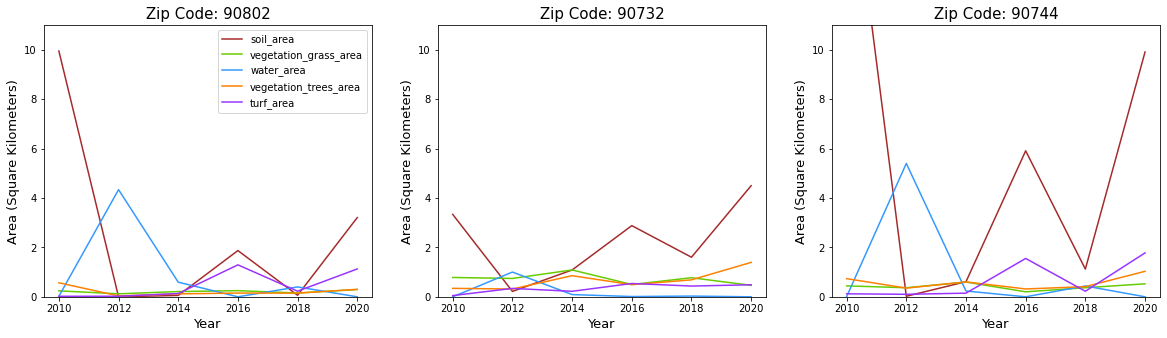

In [51]:
years= [2010, 2012, 2014, 2016, 2018, 2020]
zips = df.polygon.unique()
fig, ax = plt.subplots(1,3, figsize = (20,5))

labels = [ 'soil_area',
 'vegetation_grass_area',
 'water_area',
 'vegetation_trees_area',
 'turf_area']

colors = ['brown','#66CC00','#3399FF','#FF8000','#9933FF']


for i in range(3):
    for j in range(len(labels)):
        if j == 'polygon':
            continue
        else:
            d = df[df.polygon == zips[i]]
            ax[i].plot(years, d[labels[j]], color = colors[j], label = labels[j])
    ax[i].set_title(f'Zip Code: {zips[i]}', size = 15)
    ax[i].set_xlabel('Year', size = 13)
    ax[i].set_ylabel('Area (Square Kilometers)', size = 13)
    ax[i].set_ylim(0,11)
    ax[0].legend()
    
# plt.savefig(fname = 'test.png', dpi = 200)